In [2]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

In [4]:
!pip uninstall -y shapely
pip install shapely==1.5.13

SyntaxError: invalid syntax (3194481919.py, line 2)

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


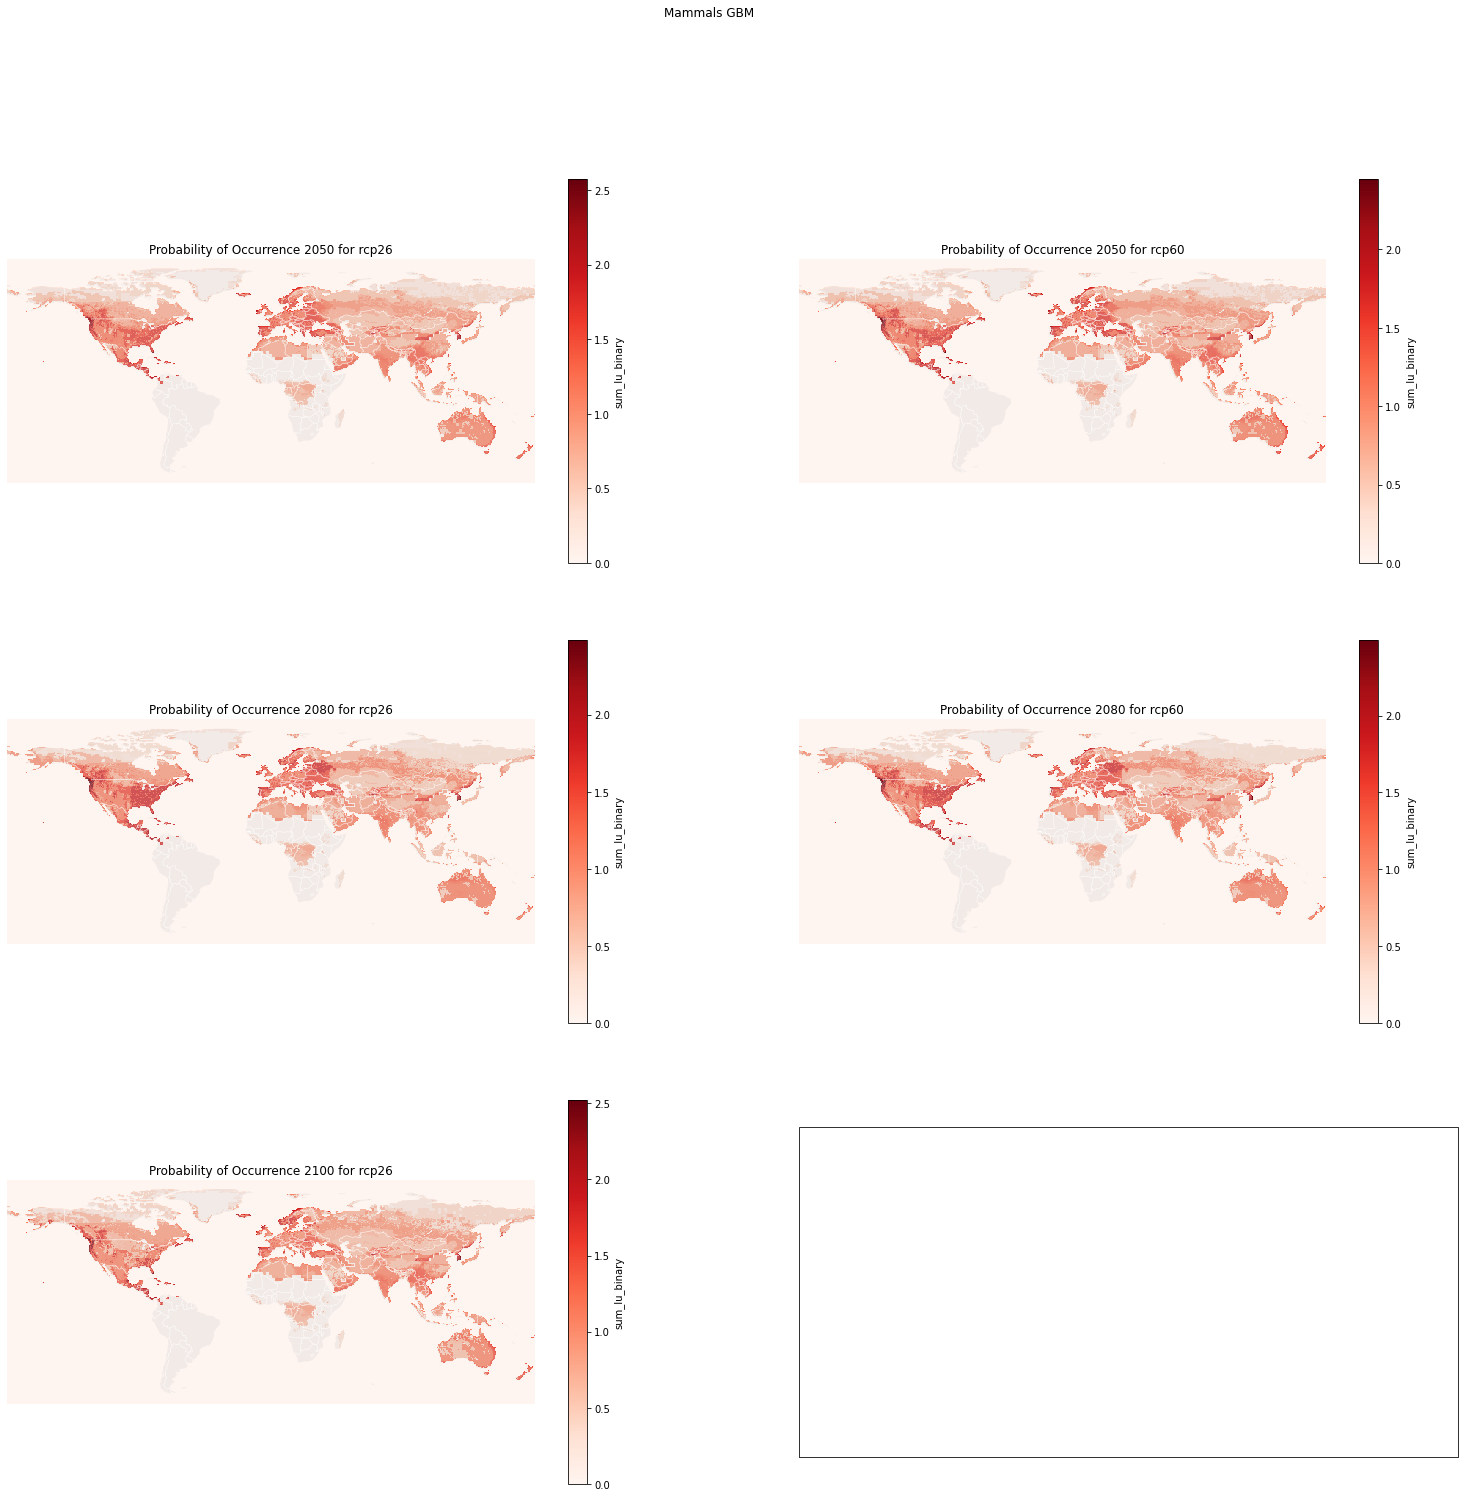

In [19]:
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
#model_names = ['GFDL-ESM2M']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:5]

   
        
        def newvalue_fun(time, model, model_names,netcdf_path_format, is_historical=False, scenario=None):
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                        sum_bin = ds["sum_lu_binary"]
                        sum_bin_dict[model][model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                bin_list = []
                for model in models:
                    for model_name in model_names:
                        sum_bin = sum_bin_dict[model][model_name][species_name]
                        bin_list.append(sum_bin)
                bin_concat = xr.concat(bin_list, dim="model")
                mean_bin = bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_bin

            bin_list = list(projections_dict.values())
            mean_bin = xr.concat(bin_list, dim="species").mean(dim="species")

            return mean_bin

future_times = [35, 65, 85]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26","rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    for scenario in scenarios:

        # Call both functions and unpack their return values
        mean_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        #mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        # Calculate the difference between the two
        # diff_bin = mean_sum_bin -mean_value_bin

        # Create three subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]
        #ax2 = axes.flatten()[plot_idx + 1]


        # Plotting code starts here
        cmap = plt.colormaps['Reds']
        #boundaries = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] # Adjust these values according to your data
        #norm = BoundaryNorm(boundaries, cmap.N)
        mean_bin_gam = mean_bin_gam.isel(time=0)
        im = mean_bin_gam.plot.imshow(x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmap, ax=ax1, add_colorbar=True)
        #im = ax1.pcolormesh(mean_bin_gam['lon'].values, mean_bin_gam['lat'].values, mean_bin_gam.values, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"Probability of Occurrence {year_indices[future_time]} for {scenario}")



        ax1.axis('off')
        ax1.set_extent((-180,180,-63,90))
        ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

        #ticks_b = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        #tick_labels = [str(int(tick)) for tick in ticks_b]
        #cbar = plt.colorbar(im, ax=ax1, fraction=0.018, pad=0.03, spacing='proportional', ticks=ticks_b)
        #cbar.ax.set_yticklabels(tick_labels)
        # Increase the plot index by 2 to move to the next pair of subplots
        plt.suptitle(taxa + " " + model)
        plot_idx += 1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/scratch/local/55115049/ipykernel_22908/2796493275.py", line 75, in <module>
    mean_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
  File "/scratch/local/55115049/ipykernel_22908/2796493275.py", line 27, in newvalue_fun
    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
  File "/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/xarray/backends/api.py", line 510, in open_dataset
    engine = plugins.guess_engine(filename_or_obj)
  File "/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/xarray/backends/plugins.py", line 136, in guess_engine
    if backend.guess_can_open(store_s

TypeError: object of type 'NoneType' has no len()

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


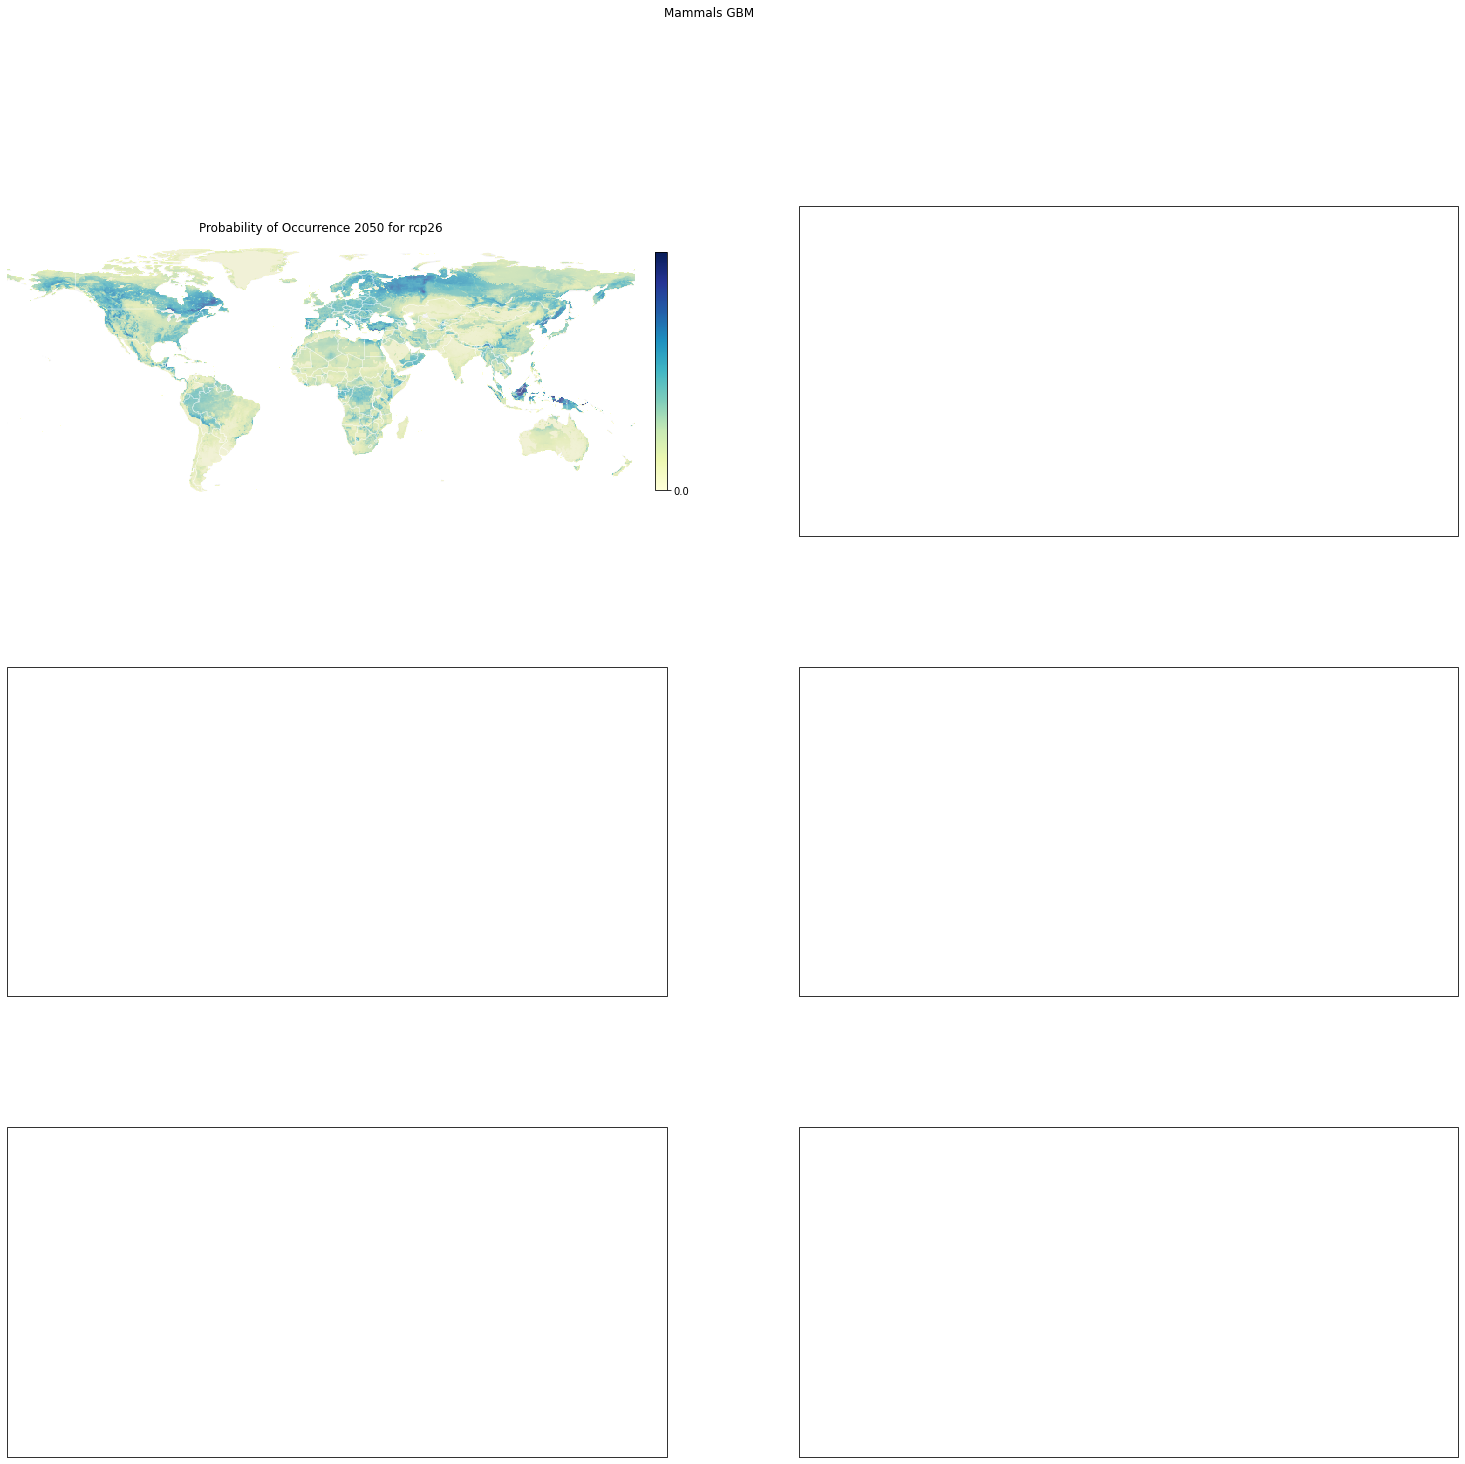

In [3]:


models=["GAM", "GBM"]
taxas=["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
#model_names = ['GFDL-ESM2M']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:100]

   
        
        def newvalue_fun(time, model, model_names,netcdf_path_format, is_historical=False, scenario=None):
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                        sum_bin = ds["sum_bin"]
                        sum_bin_dict[model][model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                bin_list = []
                for model in models:
                    for model_name in model_names:
                        sum_bin = sum_bin_dict[model][model_name][species_name]
                        bin_list.append(sum_bin)
                bin_concat = xr.concat(bin_list, dim="model")
                mean_bin = bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_bin

            bin_list = list(projections_dict.values())
            mean_bin = xr.concat(bin_list, dim="species").mean(dim="species")

            return mean_bin

future_times = [35, 65, 85]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26","rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    for scenario in scenarios:


        # Call both functions and unpack their return values
        mean_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        #mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        # Calculate the difference between the two
        # diff_bin = mean_sum_bin -mean_value_bin

        # Create three subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]
        #ax2 = axes.flatten()[plot_idx + 1]


        # Plotting code starts here
        cmap = plt.colormaps['YlGnBu']
        boundaries = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] # Adjust these values according to your data
        norm = BoundaryNorm(boundaries, cmap.N)
        mean_bin_gam = mean_bin_gam.isel(time=0)
        im = mean_bin_gam.plot.imshow(x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmap, ax=ax1, add_colorbar=False)
        #im = ax1.pcolormesh(mean_bin_gam['lon'].values, mean_bin_gam['lat'].values, mean_bin_gam.values, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"Weighted Probability of Occurrence {year_indices[future_time]} for {scenario}")



        ax1.axis('off')
        ax1.set_extent((-180,180,-63,90))
        ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

        ticks_b = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
        tick_labels = [str(int(tick)) for tick in ticks_b]
        cbar =  plt.colorbar(im, ax=ax1, fraction=0.018, pad=0.03, spacing='proportional', ticks=ticks_b)

        # Increase the plot index by 2 to move to the next pair of subplots
        plt.suptitle(taxa + " " + model)
        plot_idx += 1

FileNotFoundError: [Errno 2] No such file or directory: b'/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/Mammals_GAM_35_rcp26_LancClim_SDM_mean_00th_mean_value_bin_future.nc'

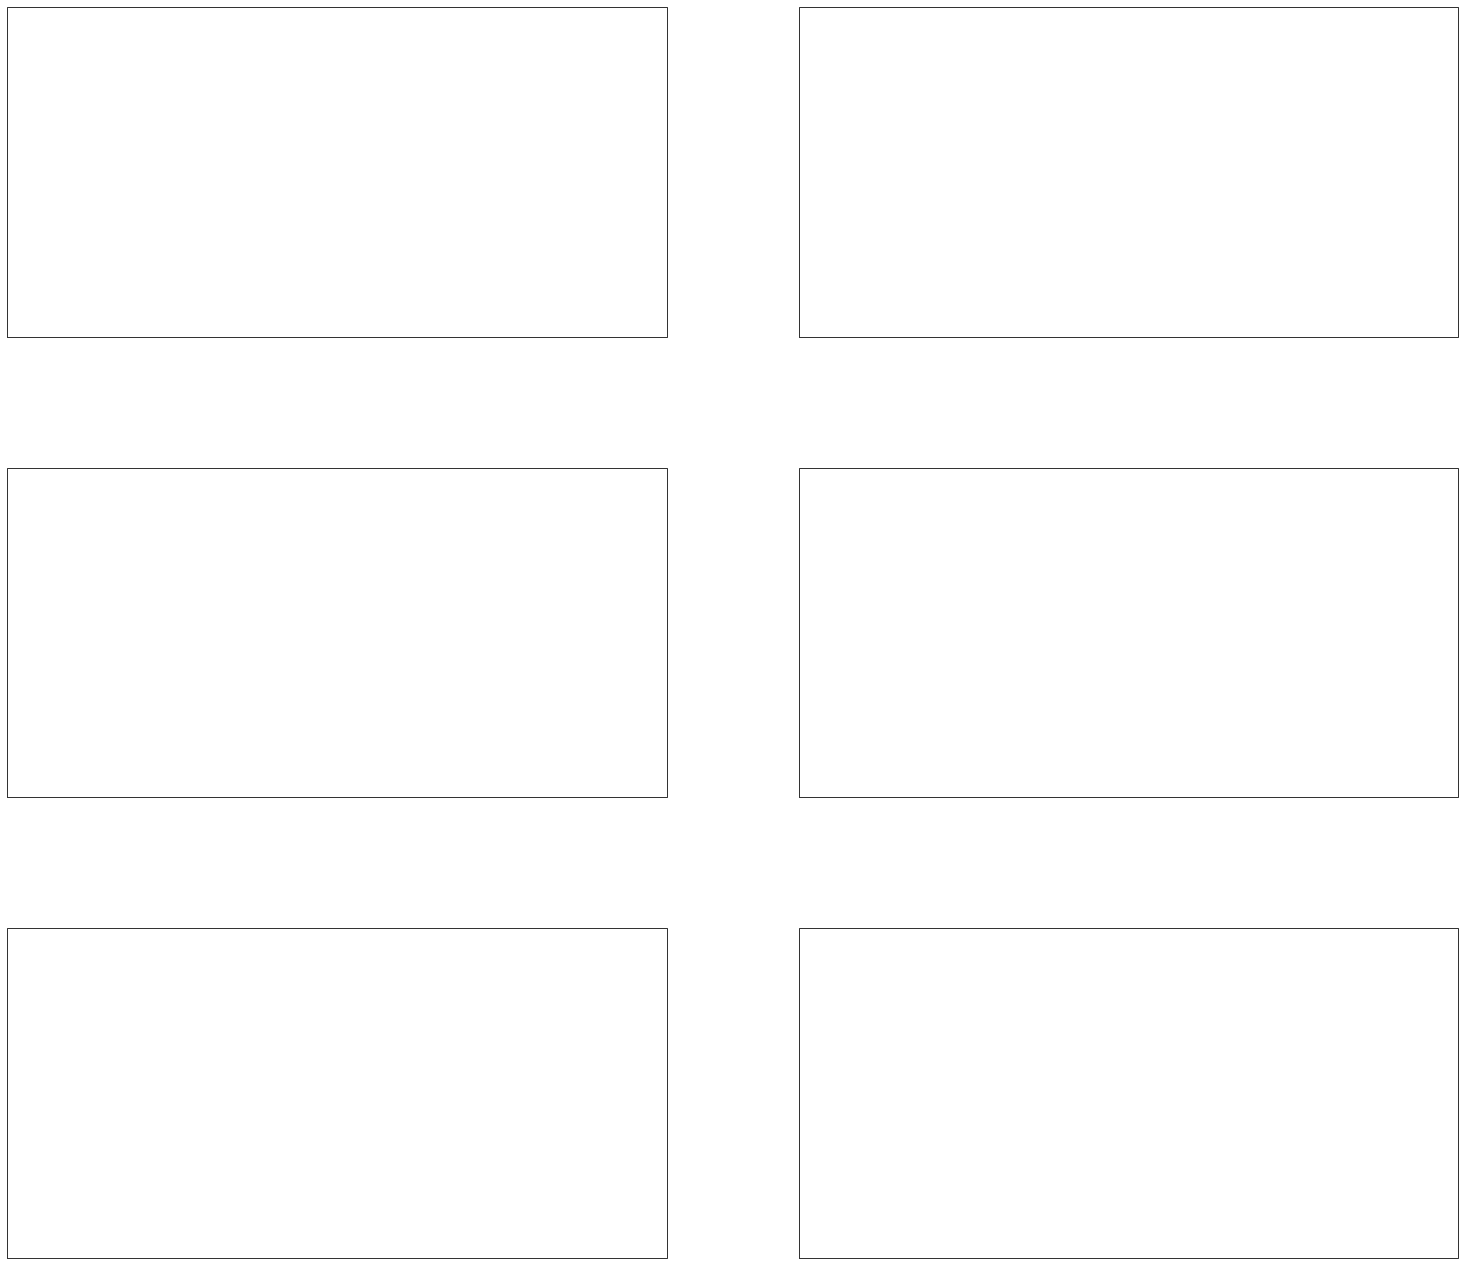

In [3]:
#### Have a plot showing the POO and weithed POO for all future steps - past ####

#### LandClim SDM ensemble #### 

models=["GAM", "GBM"]
taxas=["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']


historical_time = 1146
future_times = [35, 65, 85]
scenarios = ["rcp26", "rcp60"]
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    for model in models: 
        for taxa in taxas: 
            if future_time == 35 or future_time == 65:
                model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26", "rcp60"]
            elif future_time == 85:
                model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]

            for scenario in scenarios:
                if future_time == 85 and scenario == "rcp60":
                    continue
                filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_LancClim_SDM_mean_00th_mean_value_bin_future.nc"


                difference = xr.open_dataset(filename,decode_times=False).to_array()

                #difference = mean_future_slice - mean_hist_slice
                ax = axes.flatten()[plot_idx]
                im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False)

                countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
                ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

                cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
                #cbar.set_ticks([-0.15, 0, 0.15])

                plot_idx += 1

    # Hide the last (empty) subplot
axes.flatten()[-1].set_visible(False)
plt.suptitle(taxa+ ' Probability of Occurrence', size=16)

plt.tight_layout()
plt.show()



/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


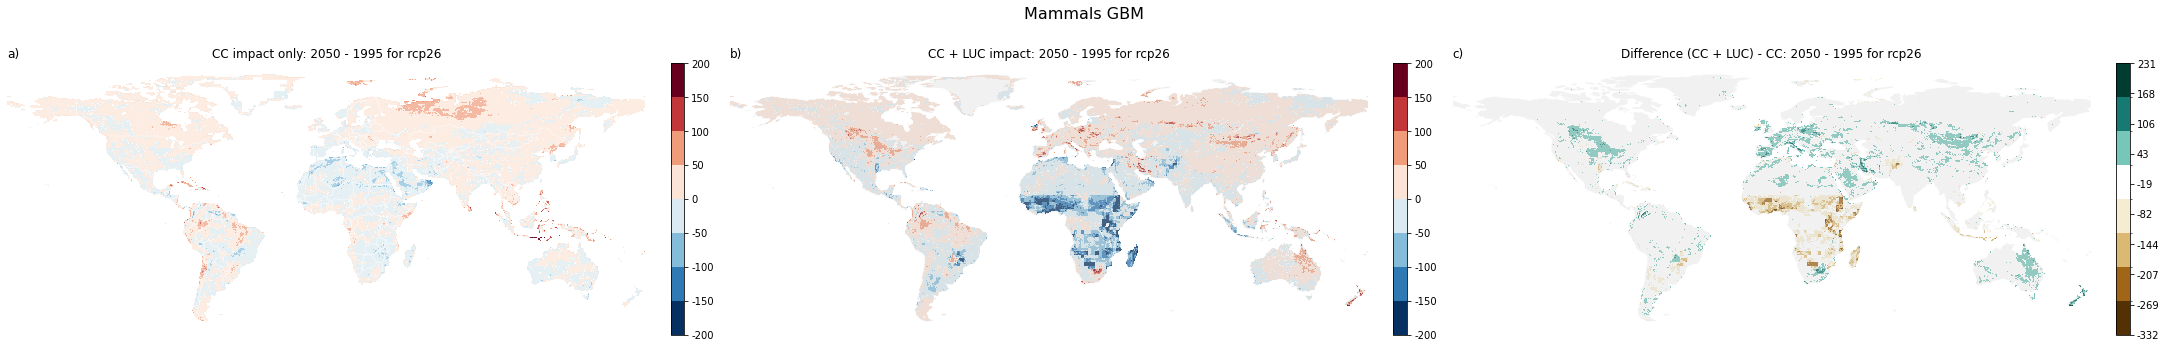

In [3]:
#### 2050 ONLY FUTURE - PAST SPECIES RICHNESS ####

labels=["a)","b)","c)"]

models = ["GBM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']
#newvalue
for taxa in taxas:
    for model in models:
        historical_time = 1146
        future_times = [35]
        scenarios = ["rcp26"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        # Add a flag to break the loop after the first future_time
        first_iteration = True

        for future_time in future_times:
            if not first_iteration:
                break

            for scenario in scenarios: 
                if future_time == 35 or future_time == 65:
                    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

                elif future_time == 85:
                    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']


                for scenario in scenarios:
                    if future_time == 85 and scenario == "rcp60":
                        continue

                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"
                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_hist =  xr.open_dataset(filename2,decode_times=False).to_array()

                    mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                    mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)

                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"
                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
                    mean_value_bin_future = mean_value_bin_future.isel(variable=0)
                    mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                    # Calculate the differences
                    diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                    diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                    diff = diff_sum_bin - diff_value_bin
                    levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]

                   # Create three subplots for each future time and scenario
                    if plot_idx >= len(axes.flatten()):
                        break

                    ax1 = axes.flatten()[plot_idx]
                    ax2 = axes.flatten()[plot_idx+1]  # Update ax2 variable
                    ax3 = axes.flatten()[plot_idx+2]  

                    # ------------------------------------------------

                    vmin_b = diff_sum_bin.min().values
                    vmax_b = diff_sum_bin.max().values


                    cmap = plt.colormaps['RdBu_r']

                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)



                    # Plot newvalue_bin in the left subplot
                    #im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values > 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="Set1", norm=norm)
                    im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values != 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
                    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax1.set_title(labels[0],loc='left')
                    ax1.axis('off')
                    ax1.set_extent((-180,180,-63,90))
                    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    #norm = BoundaryNorm(ticks_b, cmap.N)

                    #ticks_b = np.linspace(vmin_b, vmax_b, n_ticks_b)
                    #tick_labels = [str(int(round(tick, 0))) for tick in ticks_b]

                    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar1.set_ticklabels(tick_labels)


                    # ------------------------------------------------
                    # Panel b 


                    im2 = ax2.pcolormesh(diff_sum_bin['lon'].values, diff_sum_bin['lat'].values,  np.where(diff_sum_bin.values != 0, diff_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax2.set_title(labels[1],loc='left')
                    ax2.axis('off')
                    ax2.set_extent((-180,180,-63,90))
                    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar2.set_ticklabels(tick_labels)

                    # ------------------------------------------------
                    # Panel c 

                    diff_min = diff.min().values
                    diff_max = diff.max().values
                    # Define the number of boundaries and ticks to use
                    n_boundaries = 9
                    n_ticks = n_boundaries + 1
                    # Calculate the interval between boundaries and ticks
                    interval = (diff_max - diff_min) / (n_boundaries - 1)
                    # Calculate the boundaries and ticks based on the min and max values and the interval
                    new_boundaries = np.linspace(diff_min, diff_max, n_boundaries)
                    new_ticks = np.linspace(diff_min, diff_max, n_ticks)
                    # Create the custom colormap and normalization
                    n_categories = len(new_boundaries) - 1
                    colors = plt.cm.BrBG(np.linspace(0, 1, n_categories))
                    colors[len(colors) // 2] = [1, 1, 1, 1]  # Replace the middle color with white
                    custom_cmap = ListedColormap(colors)
                    norm3 = BoundaryNorm(new_boundaries, custom_cmap.N)

                    im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values, diff.values, transform=ccrs.PlateCarree(), cmap=custom_cmap, norm=norm3)

                    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                    ax3.set_title(f"Difference (CC + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax3.set_title(labels[2],loc='left')
                    ax3.axis('off')
                    ax3.set_extent((-180,180,-63,90))
                    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=new_ticks)
                    tick_labels = [str(int(round(tick, 0))) for tick in new_ticks]
                    cbar3.set_ticks(new_ticks)
                    cbar3.set_ticklabels(tick_labels)

            # Increase the plot index by 3 to move to the next triplet of subplots
            plot_idx += 3




        plt.suptitle(taxa+ " " + model, size=16, y=0.6)
        plt.show()

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


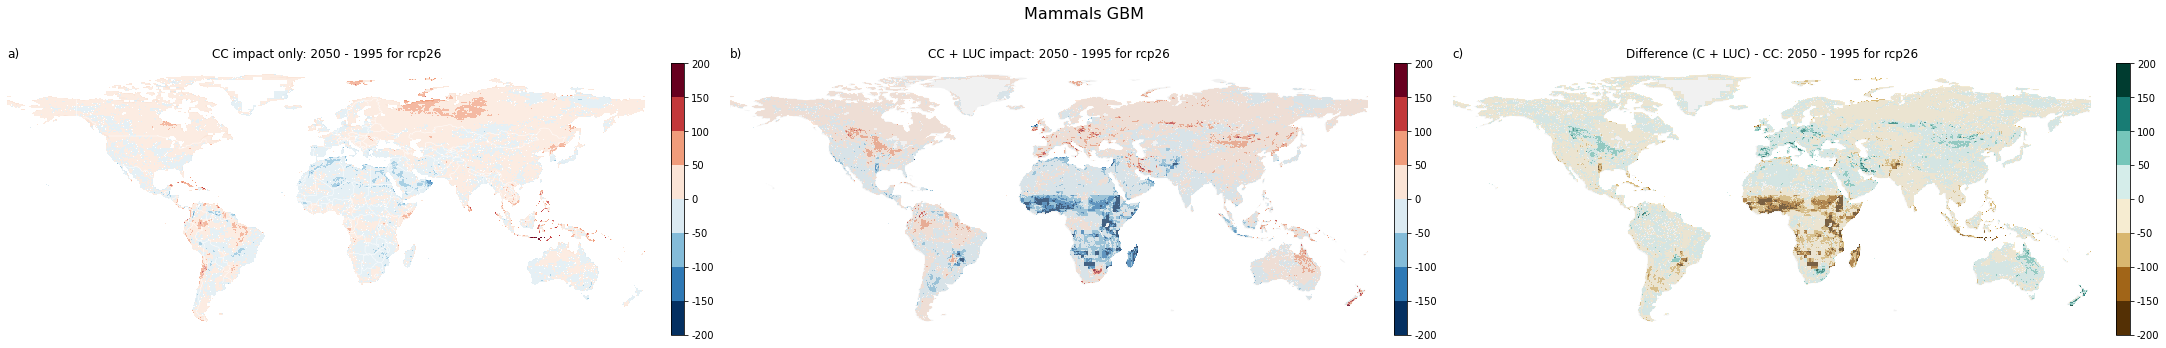

In [4]:
#### 2050 ONLY FUTURE - PAST SPECIES RICHNESS ####

labels=["a)","b)","c)"]

models = ["GBM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']
#newvalue
for taxa in taxas:
    for model in models:
        historical_time = 1146
        future_times = [35]
        scenarios = ["rcp26"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        # Add a flag to break the loop after the first future_time
        first_iteration = True

        for future_time in future_times:
            if not first_iteration:
                break

            for scenario in scenarios: 
                if future_time == 35 or future_time == 65:
                    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

                elif future_time == 85:
                    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']


                for scenario in scenarios:
                    if future_time == 85 and scenario == "rcp60":
                        continue

                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"
                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_hist =  xr.open_dataset(filename2,decode_times=False).to_array()

                    mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                    mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)

                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"
                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
                    mean_value_bin_future = mean_value_bin_future.isel(variable=0)
                    mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                    # Calculate the differences
                    diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                    diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                    diff = diff_sum_bin - diff_value_bin
                    levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]

                   # Create three subplots for each future time and scenario
                    if plot_idx >= len(axes.flatten()):
                        break

                    ax1 = axes.flatten()[plot_idx]
                    ax2 = axes.flatten()[plot_idx+1]  # Update ax2 variable
                    ax3 = axes.flatten()[plot_idx+2]  

                    # ------------------------------------------------

                    vmin_b = diff_sum_bin.min().values
                    vmax_b = diff_sum_bin.max().values


                    cmap = plt.colormaps['RdBu_r']

                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)



                    # Plot newvalue_bin in the left subplot
                    #im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values > 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="Set1", norm=norm)
                    im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values != 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
                    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax1.set_title(labels[0],loc='left')
                    ax1.axis('off')
                    ax1.set_extent((-180,180,-63,90))
                    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    #norm = BoundaryNorm(ticks_b, cmap.N)

                    #ticks_b = np.linspace(vmin_b, vmax_b, n_ticks_b)
                    #tick_labels = [str(int(round(tick, 0))) for tick in ticks_b]

                    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar1.set_ticklabels(tick_labels)


                    # ------------------------------------------------
                    # Panel b 


                    im2 = ax2.pcolormesh(diff_sum_bin['lon'].values, diff_sum_bin['lat'].values,  np.where(diff_sum_bin.values != 0, diff_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax2.set_title(labels[1],loc='left')
                    ax2.axis('off')
                    ax2.set_extent((-180,180,-63,90))
                    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar2.set_ticklabels(tick_labels)

                    # ------------------------------------------------
                    # Panel c 
                    
                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)
                    cmap = plt.colormaps['BrBG']
                

                    im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values,  np.where(diff.values != 0, diff.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                    ax3.set_title(f"Difference (C + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax3.set_title(labels[2],loc='left')
                    ax3.axis('off')
                    ax3.set_extent((-180,180,-63,90))
                    
                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    
                    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar3.set_ticklabels(tick_labels)

            # Increase the plot index by 3 to move to the next triplet of subplots
            plot_idx += 3




        plt.suptitle(taxa+ " " + model, size=16, y=0.6)
        plt.show()

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


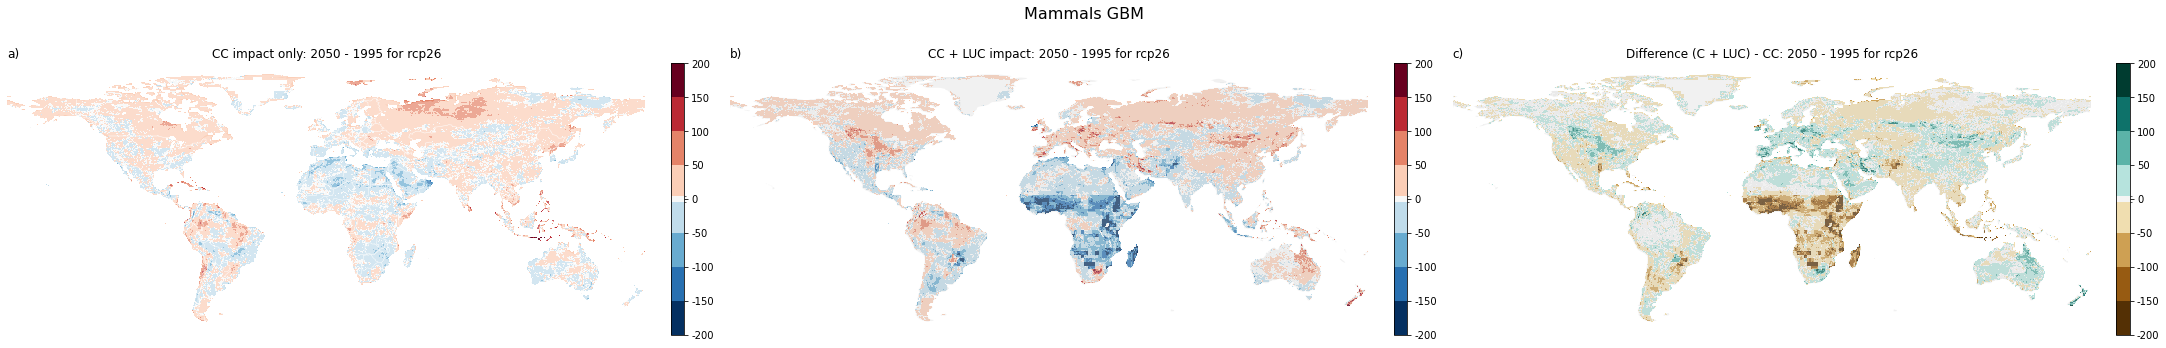

In [12]:
#### 2050 ONLY FUTURE - PAST SPECIES RICHNESS ####

labels=["a)","b)","c)"]

models = ["GBM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']
#newvalue
for taxa in taxas:
    for model in models:
        historical_time = 1146
        future_times = [35]
        scenarios = ["rcp26"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        # Add a flag to break the loop after the first future_time
        first_iteration = True

        for future_time in future_times:
            if not first_iteration:
                break

            for scenario in scenarios: 
                if future_time == 35 or future_time == 65:
                    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

                elif future_time == 85:
                    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']


                for scenario in scenarios:
                    if future_time == 85 and scenario == "rcp60":
                        continue

                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"
                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_hist =  xr.open_dataset(filename2,decode_times=False).to_array()

                    mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                    mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)

                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"
                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
                    mean_value_bin_future = mean_value_bin_future.isel(variable=0)
                    mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                    # Calculate the differences
                    diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                    diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                    diff = diff_sum_bin - diff_value_bin
                    levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]

                   # Create three subplots for each future time and scenario
                    if plot_idx >= len(axes.flatten()):
                        break

                    ax1 = axes.flatten()[plot_idx]
                    ax2 = axes.flatten()[plot_idx+1]  # Update ax2 variable
                    ax3 = axes.flatten()[plot_idx+2]  

                    # ------------------------------------------------

                    vmin_b = diff_sum_bin.min().values
                    vmax_b = diff_sum_bin.max().values


                    cmap = plt.colormaps['RdBu_r']

                    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)



                    # Plot newvalue_bin in the left subplot
                    #im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values > 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="Set1", norm=norm)
                    im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values != 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
                    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax1.set_title(labels[0],loc='left')
                    ax1.axis('off')
                    ax1.set_extent((-180,180,-63,90))
                    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    #norm = BoundaryNorm(ticks_b, cmap.N)

                    #ticks_b = np.linspace(vmin_b, vmax_b, n_ticks_b)
                    #tick_labels = [str(int(round(tick, 0))) for tick in ticks_b]

                    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar1.set_ticklabels(tick_labels)


                    # ------------------------------------------------
                    # Panel b 


                    im2 = ax2.pcolormesh(diff_sum_bin['lon'].values, diff_sum_bin['lat'].values,  np.where(diff_sum_bin.values != 0, diff_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax2.set_title(labels[1],loc='left')
                    ax2.axis('off')
                    ax2.set_extent((-180,180,-63,90))
                    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar2.set_ticklabels(tick_labels)

                    # ------------------------------------------------
                    # Panel c 
                    
                    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)
                    cmap = plt.colormaps['BrBG']
                

                    im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values,  np.where(diff.values != 0, diff.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                    ax3.set_title(f"Difference (C + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax3.set_title(labels[2],loc='left')
                    ax3.axis('off')
                    ax3.set_extent((-180,180,-63,90))
                    
                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    
                    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar3.set_ticklabels(tick_labels)

            # Increase the plot index by 3 to move to the next triplet of subplots
            plot_idx += 3




        plt.suptitle(taxa+ " " + model, size=16, y=0.6)
        plt.show()

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


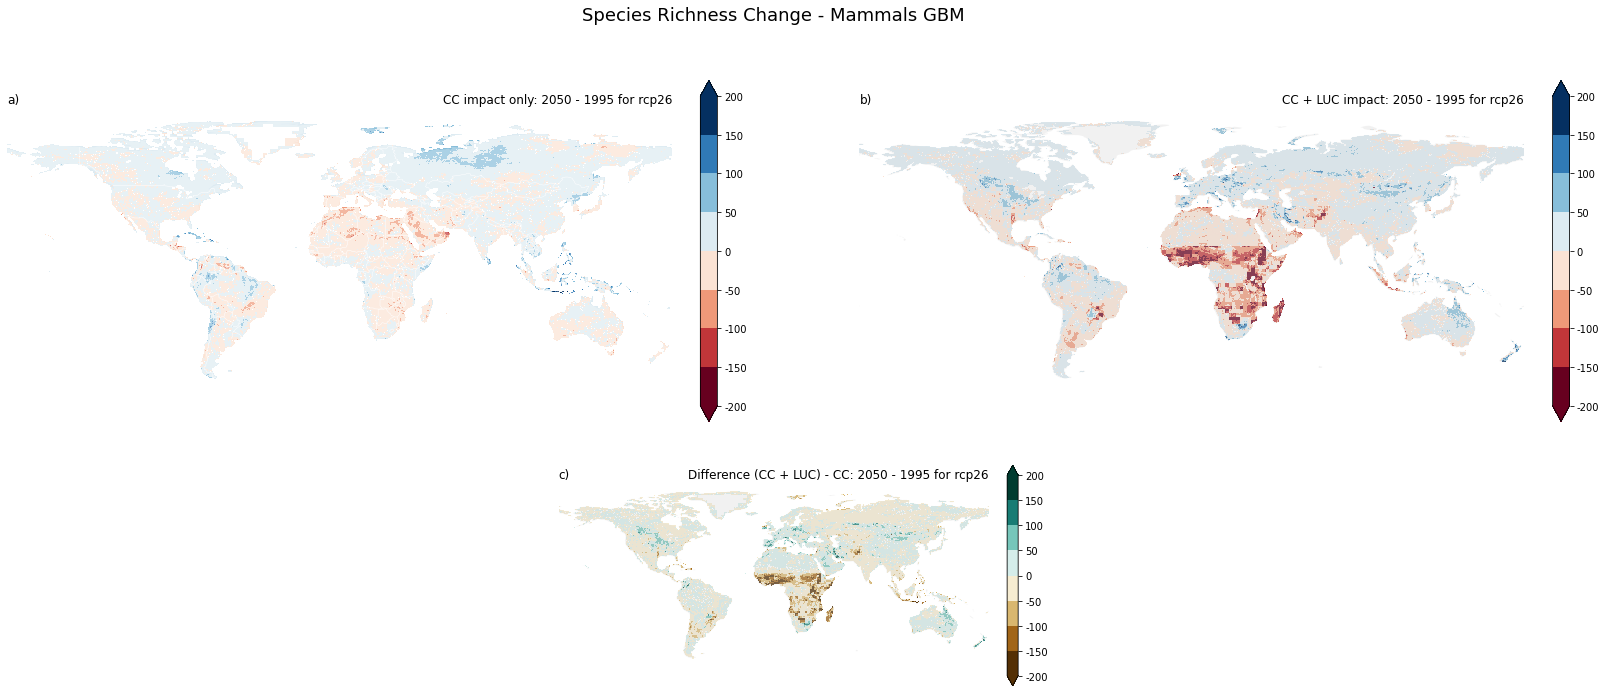

In [2]:
#### SAME AS ABOVE BUT EMPHASIZING DIFFERENCE ####

models = ["GBM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

#newvalue
for taxa in taxas:
    for model in models:
        
        historical_time = 1146
        future_times = [35]
        scenarios = ["rcp26"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        labels=["a)","b)","c)"]


        fig = plt.figure(figsize=(28,12))
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}


        for future_time in future_times:
            for scenario in scenarios: 
                if future_time == 35 or future_time == 65:
                    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

                elif future_time == 85:
                    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']


                for scenario in scenarios:
                    if future_time == 85 and scenario == "rcp60":
                        continue
                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"



                    mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_hist =  xr.open_dataset(filename2,decode_times=False).to_array()

                    mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                    mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)


                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
                    mean_value_bin_future = mean_value_bin_future.isel(variable=0)
                    mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                    # Calculate the differences
                    diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                    diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                    diff = diff_sum_bin - diff_value_bin
                    levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]
                    
                                        
                    # ------------------------------------------------
                    # Panel a 

                    ax = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1, rowspan=1, projection=ccrs.PlateCarree())

                    ax1=ax
                    vmin_b = diff_sum_bin.min().values
                    vmax_b = diff_sum_bin.max().values


                    cmap = plt.colormaps['RdBu']

                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)



                    # Plot newvalue_bin in the left subplot
                    #im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values > 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="Set1", norm=norm)
                    im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values != 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
                    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='right')
                    ax1.set_title(labels[0],loc='left')
                    ax1.axis('off')
                    ax1.set_extent((-180,180,-63,90))
                    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    #norm = BoundaryNorm(ticks_b, cmap.N)

                    #ticks_b = np.linspace(vmin_b, vmax_b, n_ticks_b)
                    #tick_labels = [str(int(round(tick, 0))) for tick in ticks_b]

                    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
                    cbar1.set_ticklabels(tick_labels)
                    
                    # ------------------------------------------------
                    # Panel b 
                    
                    ax = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
                    ax2=ax
                    im2 = ax2.pcolormesh(diff_sum_bin['lon'].values, diff_sum_bin['lat'].values,  np.where(diff_sum_bin.values != 0, diff_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='right')
                    ax2.set_title(labels[1],loc='left')
                    ax2.axis('off')
                    ax2.set_extent((-180,180,-63,90))
                    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
                    cbar2.set_ticklabels(tick_labels)

                    
                    # ------------------------------------------------
                    # Panel c 

                    
                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)
                    cmap = plt.colormaps['BrBG']
                    
                    ax = plt.subplot2grid(shape=(3,3), loc=(2, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())

                    ax3 = ax
                    im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values,  np.where(diff.values != 0, diff.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                    ax3.set_title(f"Difference (CC + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='right')
                    ax3.set_title(labels[2],loc='left')
                    ax3.axis('off')
                    ax3.set_extent((-180,180,-63,90))
                    
                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    
                    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
                    cbar3.set_ticklabels(tick_labels)
                    
# Adjust the size of the figure
        #fig = plt.gcf()
        #fig.set_size_inches(10, 6)

        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=-0.3)
        #plt.tight_layout()
        plt.title(f'Species Richness Change - {taxa} {model}', fontsize=18, y=3.5)

        fig.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/three_dim_2_up_" + taxa + "_" + model + "_" + scenario)

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


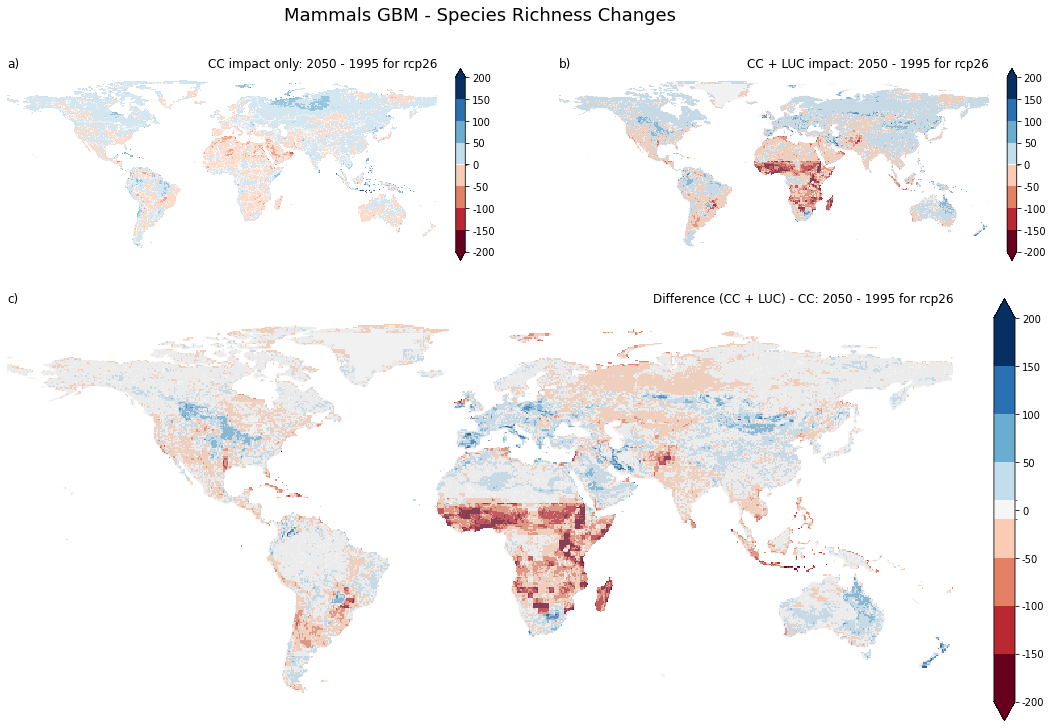

In [4]:
#### SAME AS ABOVE BUT EMPHASIZING DIFFERENCE ####

models = ["GBM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

#newvalue
for taxa in taxas:
    for model in models:
        
        historical_time = 1146
        future_times = [35]
        scenarios = ["rcp26"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        labels=["a)","b)","c)"]


        fig = plt.figure(figsize=(28,12))
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}


        for future_time in future_times:
            for scenario in scenarios: 
                if future_time == 35 or future_time == 65:
                    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

                elif future_time == 85:
                    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']


                for scenario in scenarios:
                    if future_time == 85 and scenario == "rcp60":
                        continue
                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"



                    mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_hist =  xr.open_dataset(filename2,decode_times=False).to_array()

                    mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                    mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)


                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
                    mean_value_bin_future = mean_value_bin_future.isel(variable=0)
                    mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                    # Calculate the differences
                    diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                    diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                    diff = diff_sum_bin - diff_value_bin
                    levels = [-2e2,-1.5e2,-1.0e2,-0.5e2,-0.1e1,0.1e1,0.5e2,1.0e2,1.5e2,2e2]
                    
                                        
                    # ------------------------------------------------
                    # Panel a 

                    ax = plt.subplot2grid(shape=(3,3), loc=(0,0), colspan=1, projection=ccrs.PlateCarree())
                    ax1=ax
                    vmin_b = diff_sum_bin.min().values
                    vmax_b = diff_sum_bin.max().values


                    cmap = plt.colormaps['RdBu']

                    boundaries = [-200, -150, -100, -50,-2,2,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)



                    # Plot newvalue_bin in the left subplot
                    #im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values > 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="Set1", norm=norm)
                    im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values != 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
                    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='right')
                    ax1.set_title(labels[0],loc='left')
                    ax1.axis('off')
                    ax1.set_extent((-180,180,-63,90))
                    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    #norm = BoundaryNorm(ticks_b, cmap.N)

                    #ticks_b = np.linspace(vmin_b, vmax_b, n_ticks_b)
                    #tick_labels = [str(int(round(tick, 0))) for tick in ticks_b]

                    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend="both")
                    cbar1.set_ticklabels(tick_labels)
                    
                    # ------------------------------------------------
                    # Panel b 
                    
                    ax = plt.subplot2grid(shape=(3,3), loc=(0,1), colspan=1, projection=ccrs.PlateCarree())
                    ax2=ax
                    im2 = ax2.pcolormesh(diff_sum_bin['lon'].values, diff_sum_bin['lat'].values,  np.where(diff_sum_bin.values != 0, diff_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='right')
                    ax2.set_title(labels[1],loc='left')
                    ax2.axis('off')
                    ax2.set_extent((-180,180,-63,90))
                    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
                    cbar2.set_ticklabels(tick_labels)

                    
                    # ------------------------------------------------
                    # Panel c 

                    
                    boundaries = [-200, -150, -100, -50,-10,10,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)
                    cmap = plt.colormaps['RdBu']
                    
                    ax = plt.subplot2grid(shape=(3,3), loc=(1,0), colspan=2, rowspan=2, projection=ccrs.PlateCarree())
                    ax3 = ax
                    im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values,  np.where(diff.values != 0, diff.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                    ax3.set_title(f"Difference (CC + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='right')
                    ax3.set_title(labels[2],loc='left')
                    ax3.axis('off')
                    ax3.set_extent((-180,180,-63,90))
                    
                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    
                    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
                    cbar3.set_ticklabels(tick_labels)

        #plt.tight_layout()
        plt.title(f'{taxa} {model} - Species Richness Changes', fontsize=18, y=1.7)
        plt.show() 
        fig.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/three_dim_1_down_" + taxa + "_" + model + "_" + scenario)

In [ ]:
#### COMPARE RCP26 AND RCP60 ######


/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWar

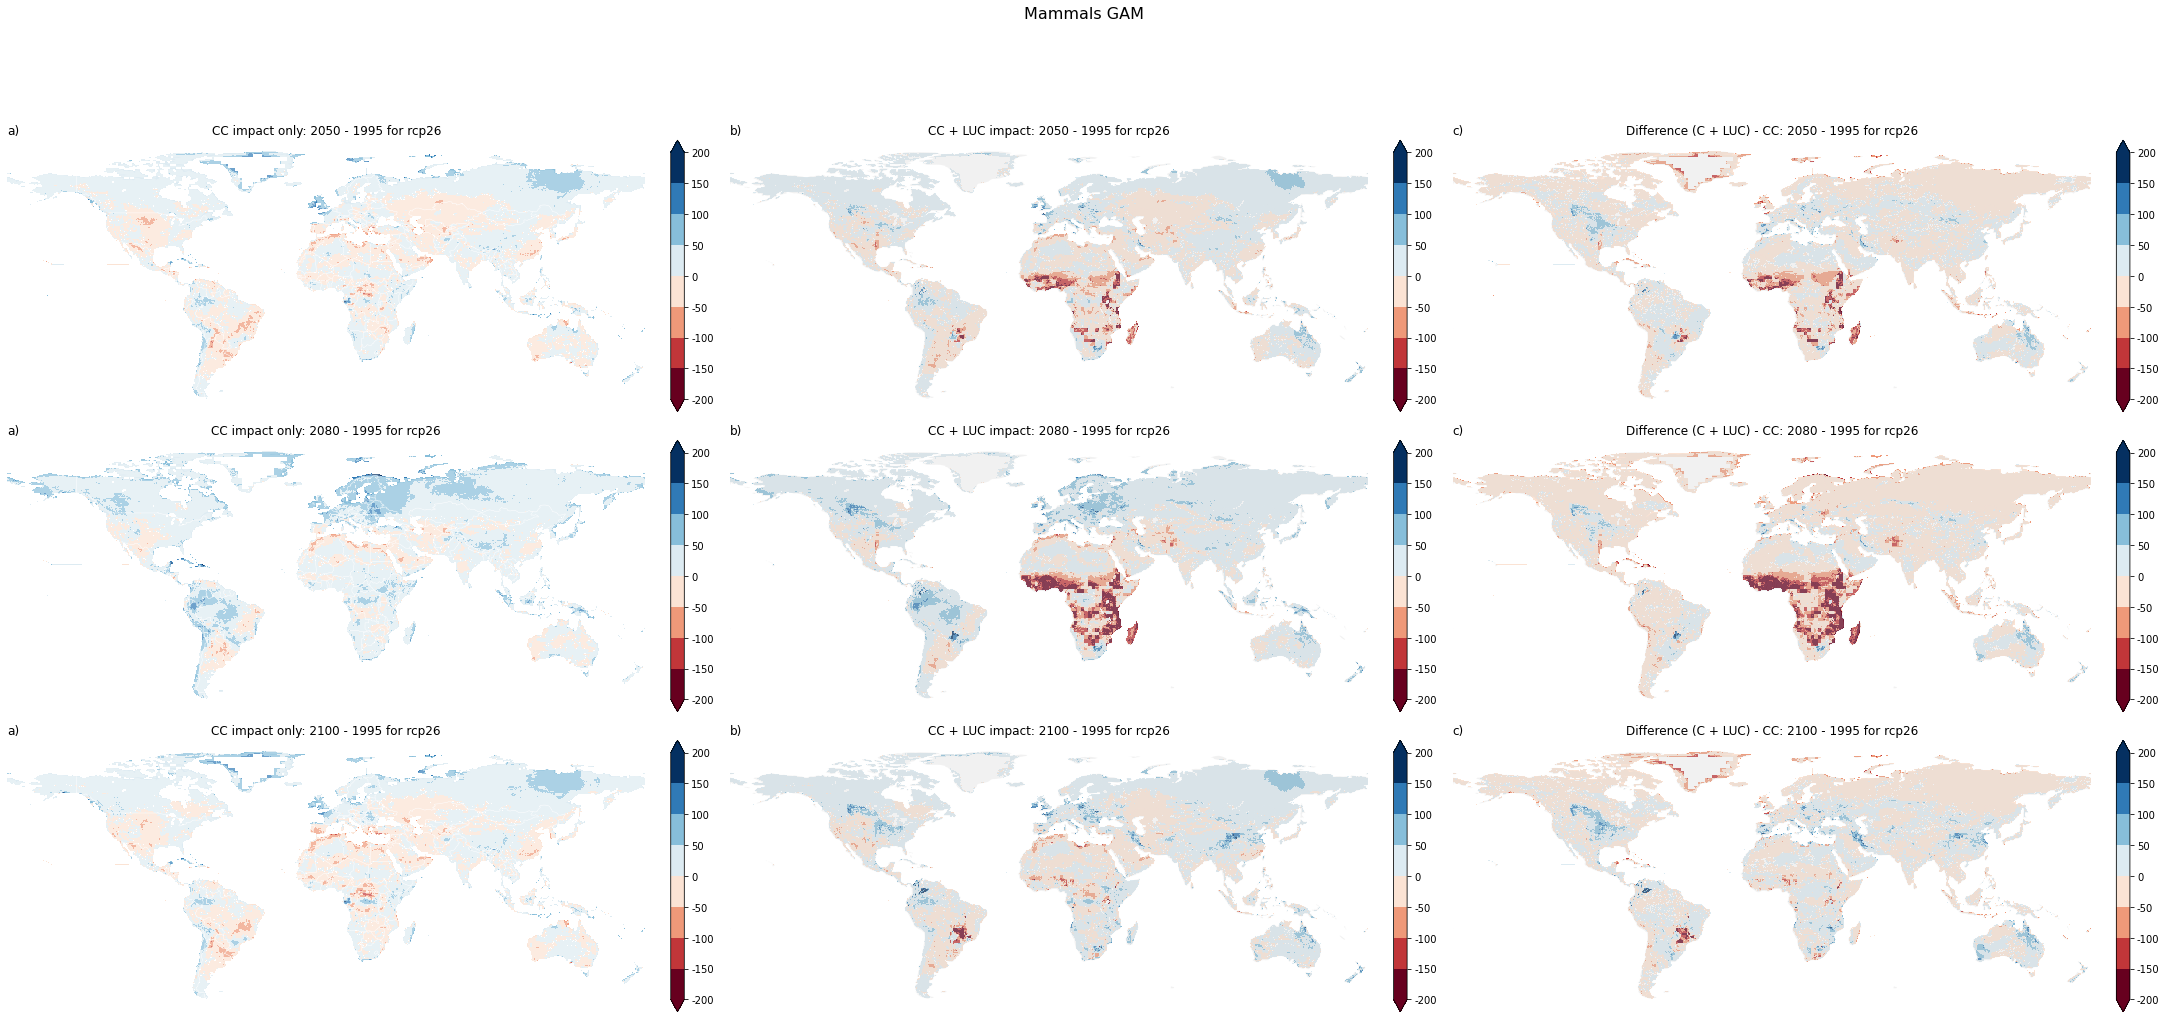

In [7]:
##### PLOT WITH ALL YEARS ONE SCENARIO AT A TIME ####

models = ["GAM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]

species_names = available_names

#newvalue
for taxa in taxas:
    for model in models:
        
        historical_time = 1146
        future_times = [35, 65, 85]
        scenarios = ["rcp26"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        for future_time in future_times:
            for scenario in scenarios: 
                if future_time == 35 or future_time == 65:
                    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

                elif future_time == 85:
                    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']


                for scenario in scenarios:
                    if future_time == 85 and scenario == "rcp60":
                        continue
                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"



                    mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_hist =  xr.open_dataset(filename2,decode_times=False).to_array()

                    mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                    mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)


                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
                    mean_value_bin_future = mean_value_bin_future.isel(variable=0)
                    mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                    # Calculate the differences
                    diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                    diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                    diff = diff_sum_bin - diff_value_bin

                   # Create three subplots for each future time and scenario
                    if plot_idx >= len(axes.flatten()):
                        break
                    ax1 = axes.flatten()[plot_idx]
                    ax2 = axes.flatten()[plot_idx + 1]
                    ax3 = axes.flatten()[plot_idx + 2]
                    #cmap = colors.ListedColormap(['#e41a1c','#1f78b4', '#377eb8', '#ff7f00', '#984ea3', '#4daf4a','#ffff33','#a65628','#f781bf','#999999'])
                    
                    # ------------------------------------------------
                    # Panel a 
                    vmin_b = diff_sum_bin.min().values
                    vmax_b = diff_sum_bin.max().values


                    cmap = plt.colormaps['RdBu']

                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)



                    # Plot newvalue_bin in the left subplot
                    #im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values > 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="Set1", norm=norm)
                    im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values != 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
                    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax1.set_title(labels[0],loc='left')
                    ax1.axis('off')
                    ax1.set_extent((-180,180,-63,90))
                    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    #norm = BoundaryNorm(ticks_b, cmap.N)

                    #ticks_b = np.linspace(vmin_b, vmax_b, n_ticks_b)
                    #tick_labels = [str(int(round(tick, 0))) for tick in ticks_b]

                    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
                    cbar1.set_ticklabels(tick_labels)

                    # ------------------------------------------------
                    # Panel b 

                    im2 = ax2.pcolormesh(diff_sum_bin['lon'].values, diff_sum_bin['lat'].values,  np.where(diff_sum_bin.values != 0, diff_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax2.set_title(labels[1],loc='left')
                    ax2.axis('off')
                    ax2.set_extent((-180,180,-63,90))
                    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
                    cbar2.set_ticklabels(tick_labels)

                    
                    # ------------------------------------------------
                    # Panel c 

                    
                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)
                    cmap = plt.colormaps['RdBu']
                    
                    im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values,  np.where(diff.values != 0, diff.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                    ax3.set_title(f"Difference (C + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax3.set_title(labels[2],loc='left')
                    ax3.axis('off')
                    ax3.set_extent((-180,180,-63,90))
                    
                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    
                    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,  extend='both')
                    cbar3.set_ticklabels(tick_labels)
                    # Increase the plot index by 3 to move to the next triplet of subplots
                    plot_idx += 3


        #plt.tight_layout()
        plt.suptitle(taxa+ " " + model, size=16, y=0.8)
        plt.show() 

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWar

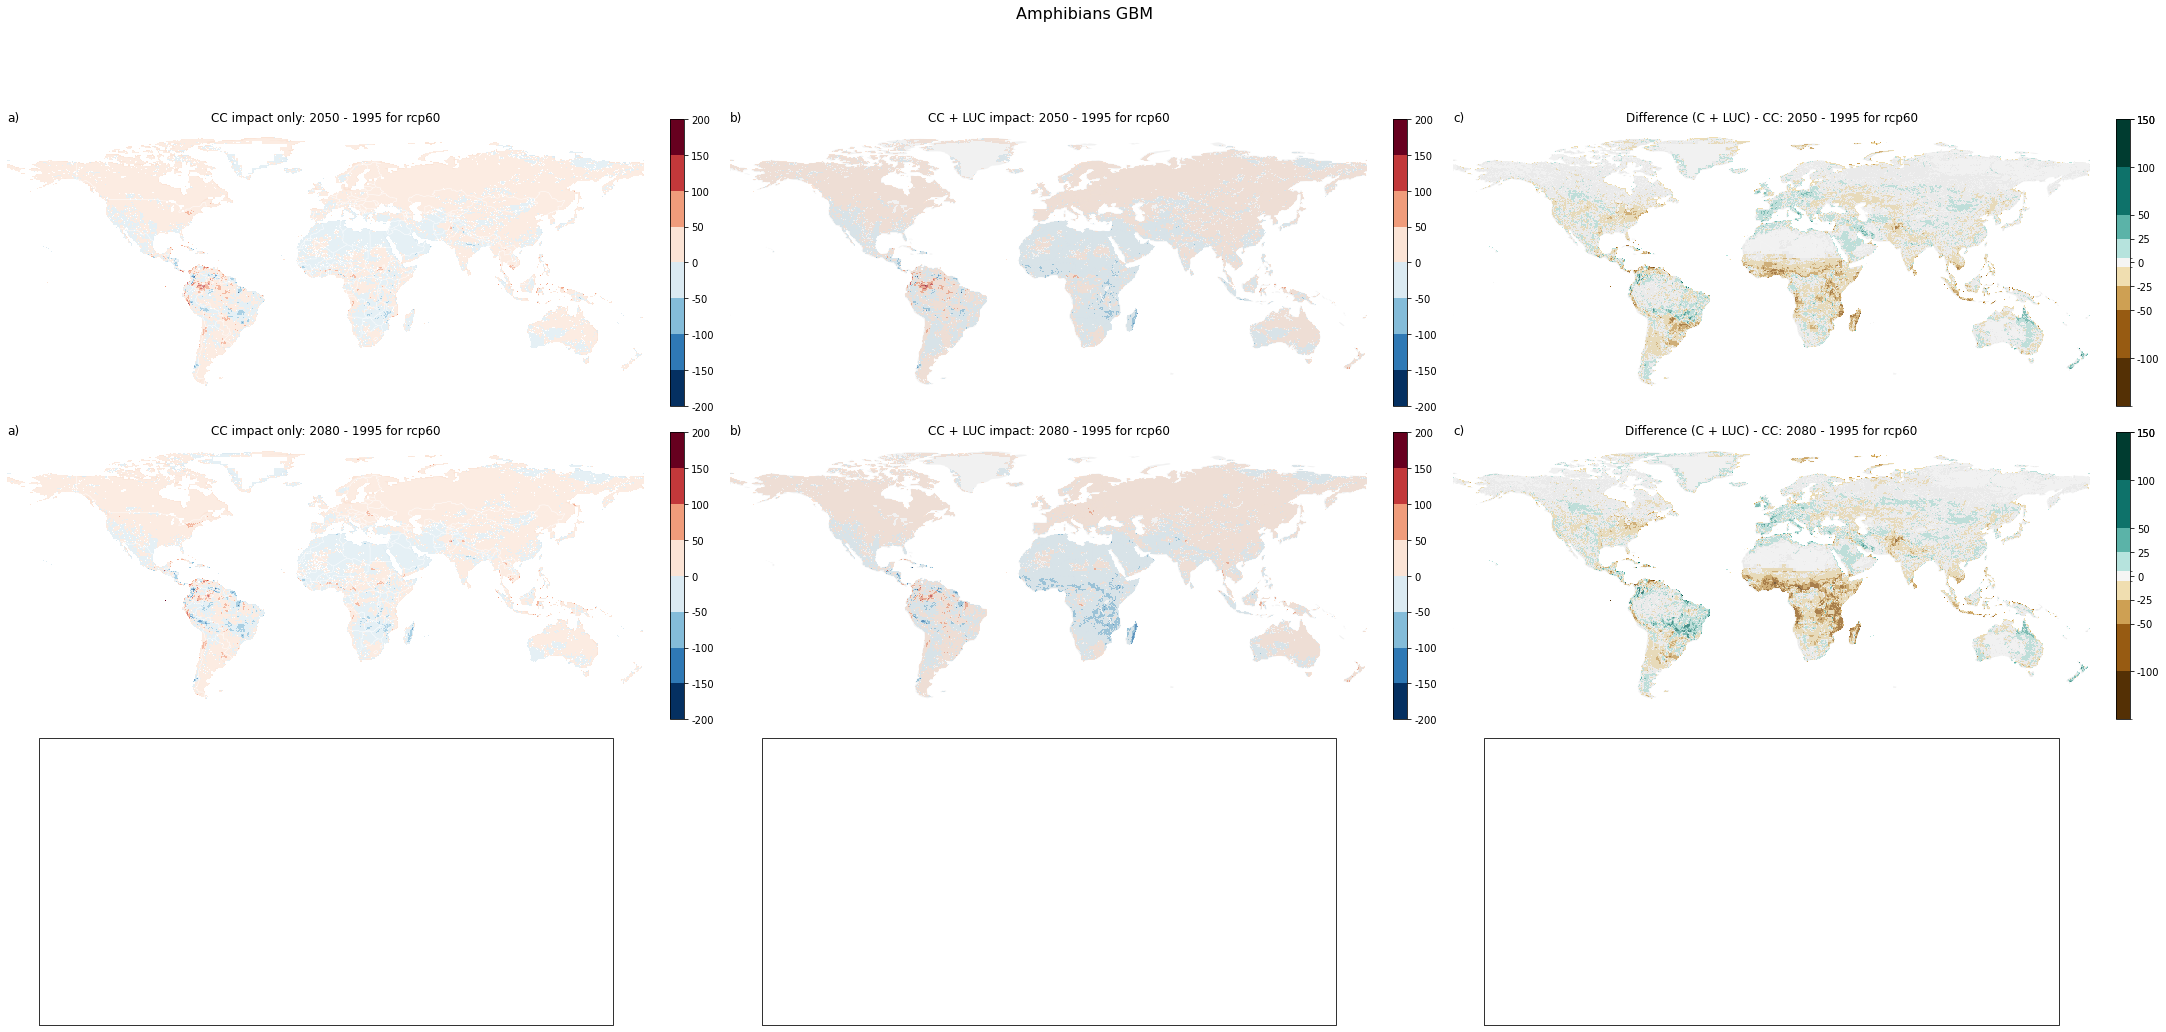

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWar

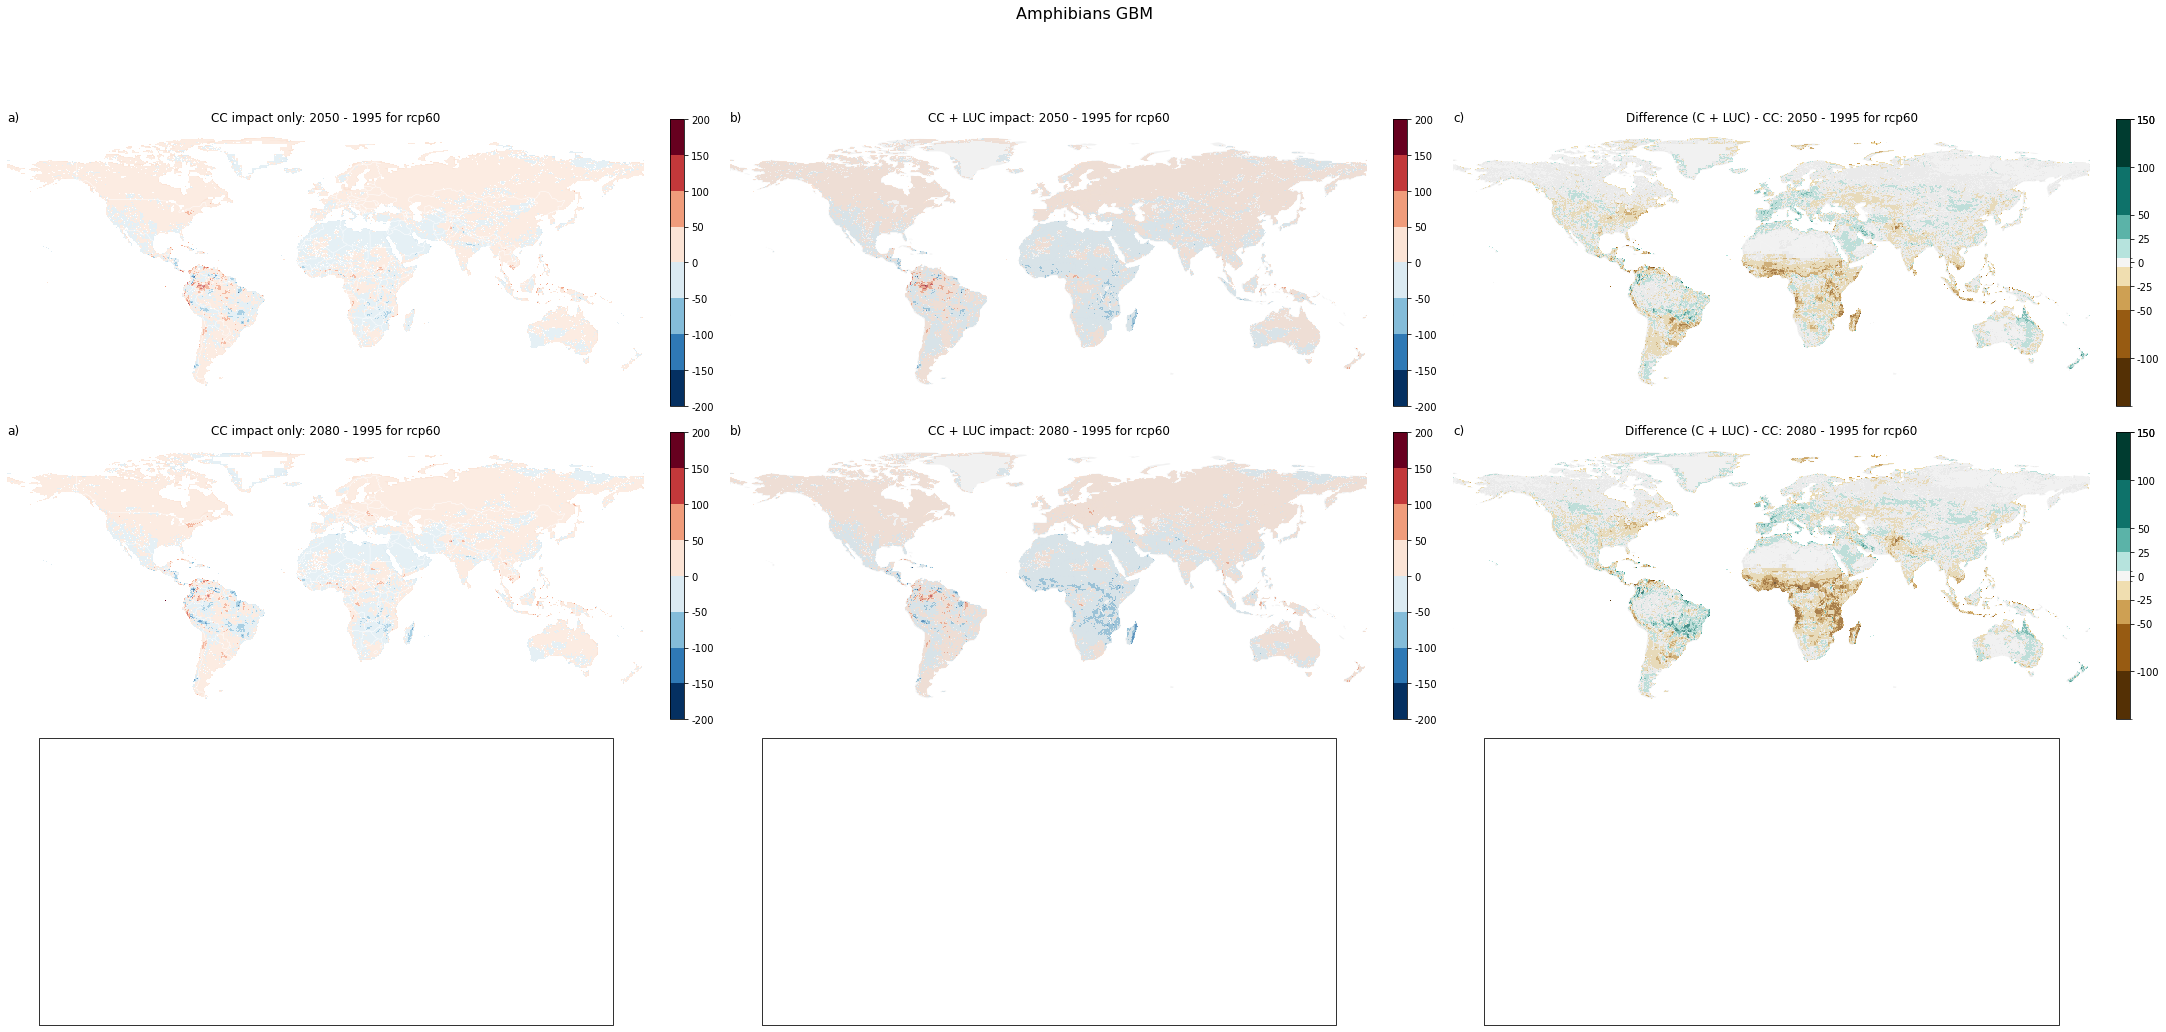

In [7]:
models = ["GBM", "GBM"]
taxas = ["Amphibians"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

#newvalue
for taxa in taxas:
    for model in models:
        
        historical_time = 1146
        future_times = [35, 65, 85]
        scenarios = ["rcp60"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        # create empty arrays for storing the results
        diff_value_bin_combined = np.zeros([360, 720])
        diff_sum_bin_combined = np.zeros([360, 720])
        diff_combined = np.zeros([360, 720])

        for future_time in future_times:
            for scenario in scenarios: 
                if future_time == 35 or future_time == 65:
                    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

                elif future_time == 85:
                    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']


                for scenario in scenarios:
                    if future_time == 85 and scenario == "rcp60":
                        continue
                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    

                    mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_hist =  xr.open_dataset(filename2,decode_times=False).to_array()

                    mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                    mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)


                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
                    mean_value_bin_future = mean_value_bin_future.isel(variable=0)
                    mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                    # Calculate the differences
                    diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                    diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                    diff = diff_sum_bin - diff_value_bin

                    # Create three subplots for each future time and scenario
                    if plot_idx >= len(axes.flatten()):
                        break
                    ax1 = axes.flatten()[plot_idx]
                    ax2 = axes.flatten()[plot_idx + 1]
                    ax3 = axes.flatten()[plot_idx + 2]

                    # Define the colormap and the range of values for the colorbar
                    vmin_b = diff_sum_bin.min().values
                    vmax_b = diff_sum_bin.max().values

                    cmap = plt.colormaps['RdBu_r']
                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)

                    # Plot the difference for each panel
                    im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values != 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
                    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax1.set_title(labels[0],loc='left')
                    ax1.axis('off')
                    ax1.set_extent((-180,180,-63,90))
                    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]

                    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar1.set_ticklabels(tick_labels)

                    
                    im2 = ax2.pcolormesh(diff_sum_bin['lon'].values, diff_sum_bin['lat'].values,  np.where(diff_sum_bin.values != 0, diff_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                                                                                                           
                    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax2.set_title(labels[1],loc='left')
                    ax2.axis('off')
                    ax2.set_extent((-180,180,-63,90))
                    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar2.set_ticklabels(tick_labels)

                    
                    # ------------------------------------------------
                    # Panel c 

                    
                    boundaries = [-150, -100, -50,-25,-5,5,25,50, 100, 150 ] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)
                    cmap = plt.colormaps['BrBG']
                    
                    im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values,  np.where(diff.values != 0, diff.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                    ax3.set_title(f"Difference (C + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax3.set_title(labels[2],loc='left')
                    ax3.axis('off')
                    ax3.set_extent((-180,180,-63,90))
                    
                    ticks_b = np.array( [--150, -100, -50,-25,0,25,50, 100, 150 ])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    
                    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar3.set_ticklabels(tick_labels)
                    # Increase the plot index by 3 to move to the next triplet of subplots
                    plot_idx += 3


        #plt.tight_layout()
        plt.suptitle(taxa + " " + model, size=16, y=0.8)
        plt.show() 

NameError: name 'labels' is not defined

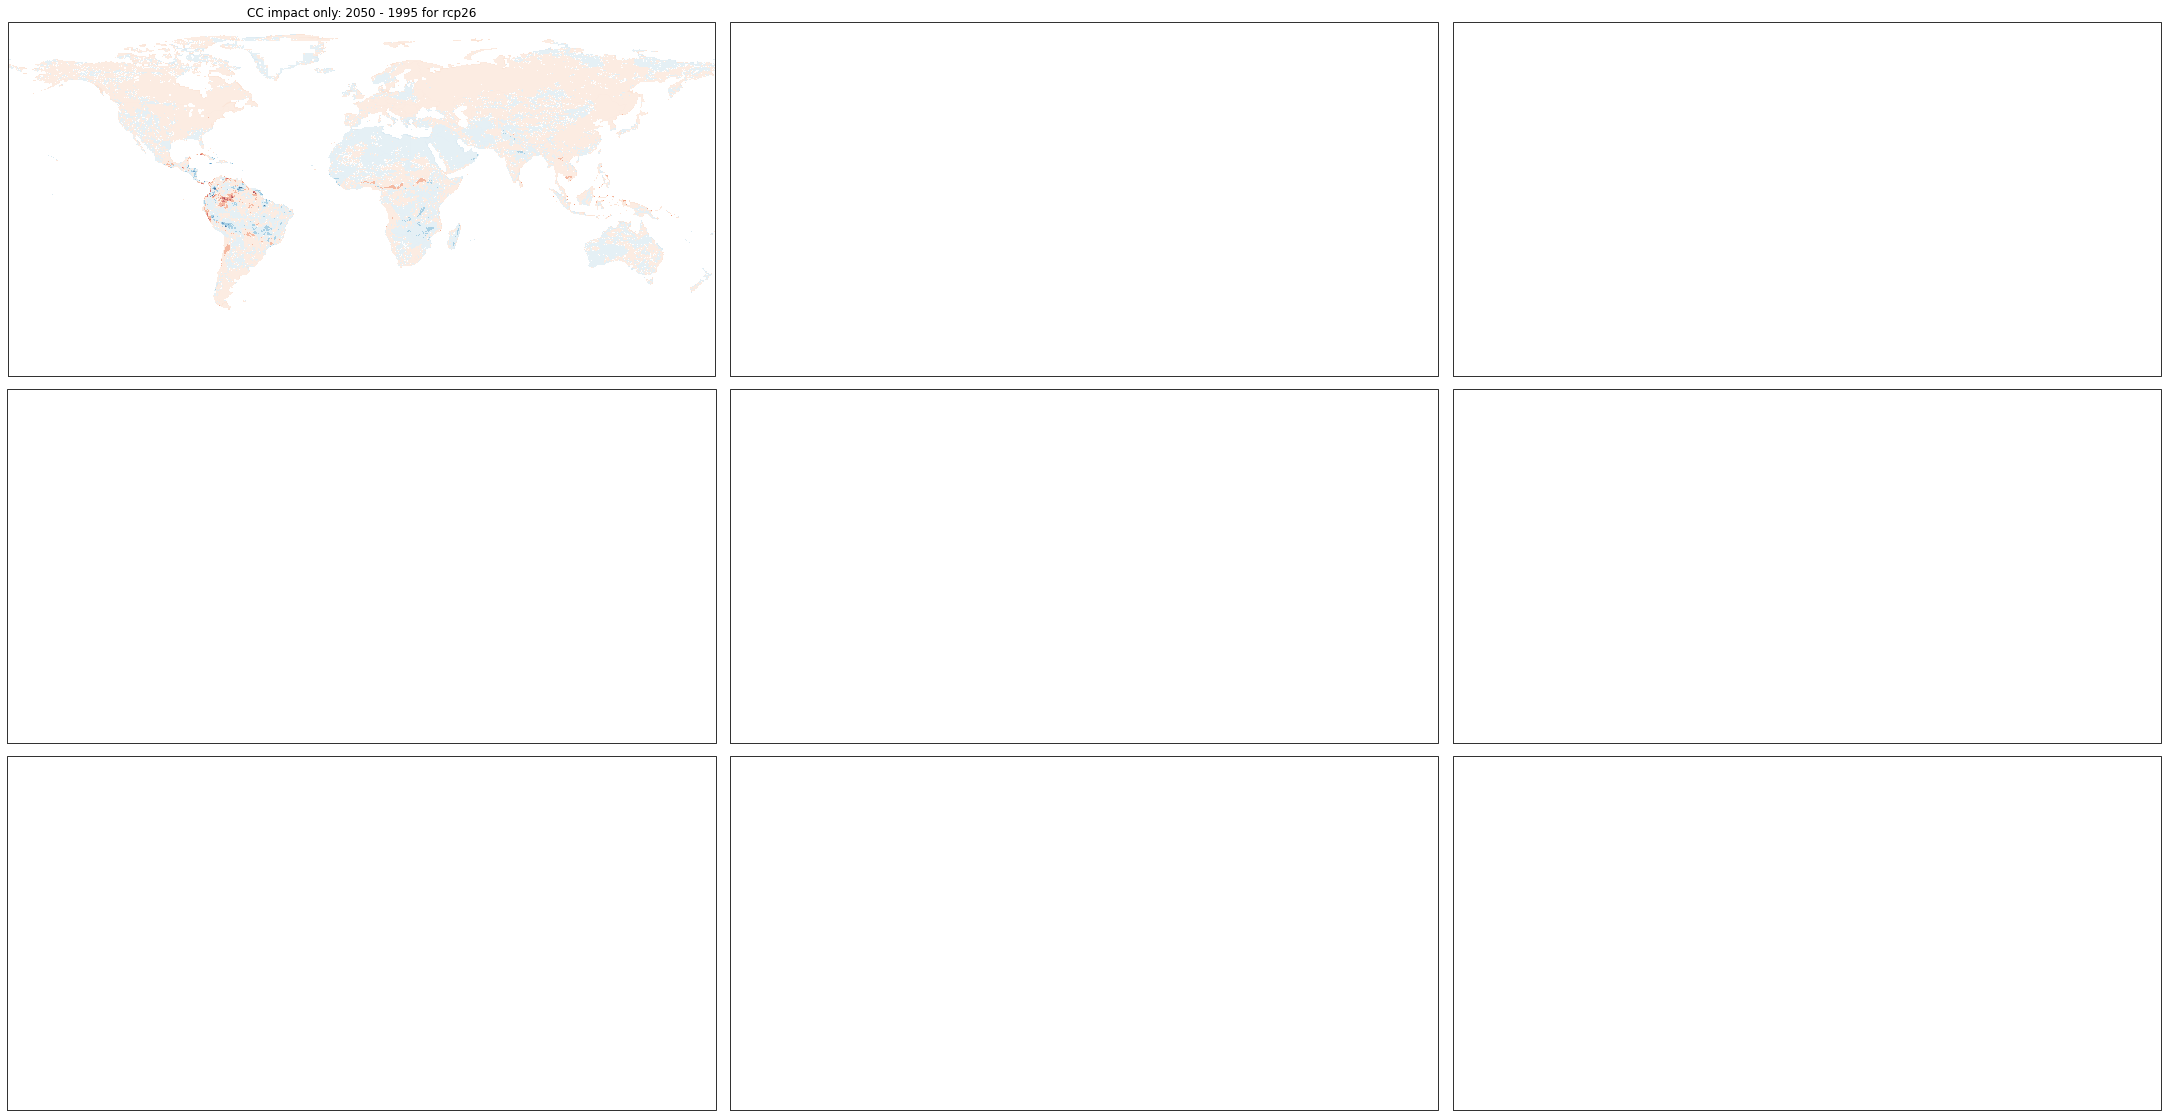

In [2]:
models = ["GBM", "GAM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

#newvalue
for taxa in taxas:
    for model in models:
        
        historical_time = 1146
        future_times = [35, 65, 85]
        scenarios = ["rcp26"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        # create empty arrays for storing the results
        diff_value_bin_combined = np.zeros([360, 720])
        diff_sum_bin_combined = np.zeros([360, 720])
        diff_combined = np.zeros([360, 720])

        for future_time in future_times:
            for scenario in scenarios: 
                if future_time == 35 or future_time == 65:
                    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

                elif future_time == 85:
                    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']


                for scenario in scenarios:
                    if future_time == 85 and scenario == "rcp60":
                        continue
                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    

                    mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_hist =  xr.open_dataset(filename2,decode_times=False).to_array()

                    mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                    mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)


                    filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

                    filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

                    mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
                    mean_value_bin_future = mean_value_bin_future.isel(variable=0)
                    mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                    # Calculate the differences
                    diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                    diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                    diff = diff_sum_bin - diff_value_bin

                    # Create three subplots for each future time and scenario
                    if plot_idx >= len(axes.flatten()):
                        break
                    ax1 = axes.flatten()[plot_idx]
                    ax2 = axes.flatten()[plot_idx + 1]
                    ax3 = axes.flatten()[plot_idx + 2]

                    # Define the colormap and the range of values for the colorbar
                    vmin_b = diff_sum_bin.min().values
                    vmax_b = diff_sum_bin.max().values

                    cmap = plt.colormaps['RdBu_r']
                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)

                    # Plot the difference for each panel
                    im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values != 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
                    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
                    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax1.set_title(labels[0],loc='left')
                    ax1.axis('off')
                    ax1.set_extent((-180,180,-63,90))
                    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]

                    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar1.set_ticklabels(tick_labels)

                    
                    im2 = ax2.pcolormesh(diff_sum_bin['lon'].values, diff_sum_bin['lat'].values,  np.where(diff_sum_bin.values != 0, diff_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                                                                                                           
                    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax2.set_title(labels[1],loc='left')
                    ax2.axis('off')
                    ax2.set_extent((-180,180,-63,90))
                    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar2.set_ticklabels(tick_labels)

                    
                    # ------------------------------------------------
                    # Panel c 

                    
                    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
                    norm = BoundaryNorm(boundaries, cmap.N)
                    cmap = plt.colormaps['BrBG']
                    
                    im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values,  np.where(diff.values != 0, diff.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                    ax3.set_title(f"Difference (C + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
                    ax3.set_title(labels[2],loc='left')
                    ax3.axis('off')
                    ax3.set_extent((-180,180,-63,90))
                    
                    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                    tick_labels = [str(int(tick)) for tick in ticks_b]
                    
                    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
                    cbar3.set_ticklabels(tick_labels)
                    # Increase the plot index by 3 to move to the next triplet of subplots
                    plot_idx += 3


        #plt.tight_layout()
        plt.suptitle(taxa + " " + model, size=16, y=0.8)
        plt.show() 

In [20]:
diff_sum_bin_ensemble.min()

<xarray.DataArray ()>
array(-301.5)
Coordinates:
    variable  <U7 'sum_bin'

In [18]:
diff_sum_bin_ensemble.max()

<xarray.DataArray ()>
array(213.)
Coordinates:
    variable  <U7 'sum_bin'

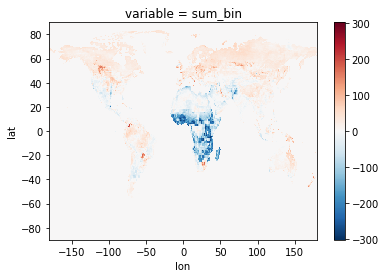

In [17]:
diff_sum_bin_ensemble.plot()

In [22]:
diff_sum_bin_ensemble.min()

<xarray.DataArray ()>
array(-301.5)
Coordinates:
    variable  <U7 'sum_bin'

In [23]:
diff_sum_bin_ensemble.max()

<xarray.DataArray ()>
array(215.)
Coordinates:
    variable  <U7 'sum_bin'

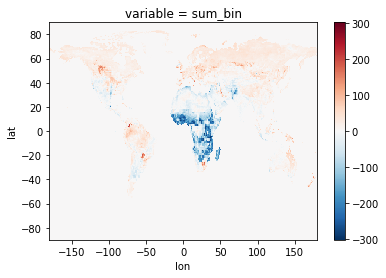

In [25]:
diff_sum_bin_ensemble.plot()

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWar

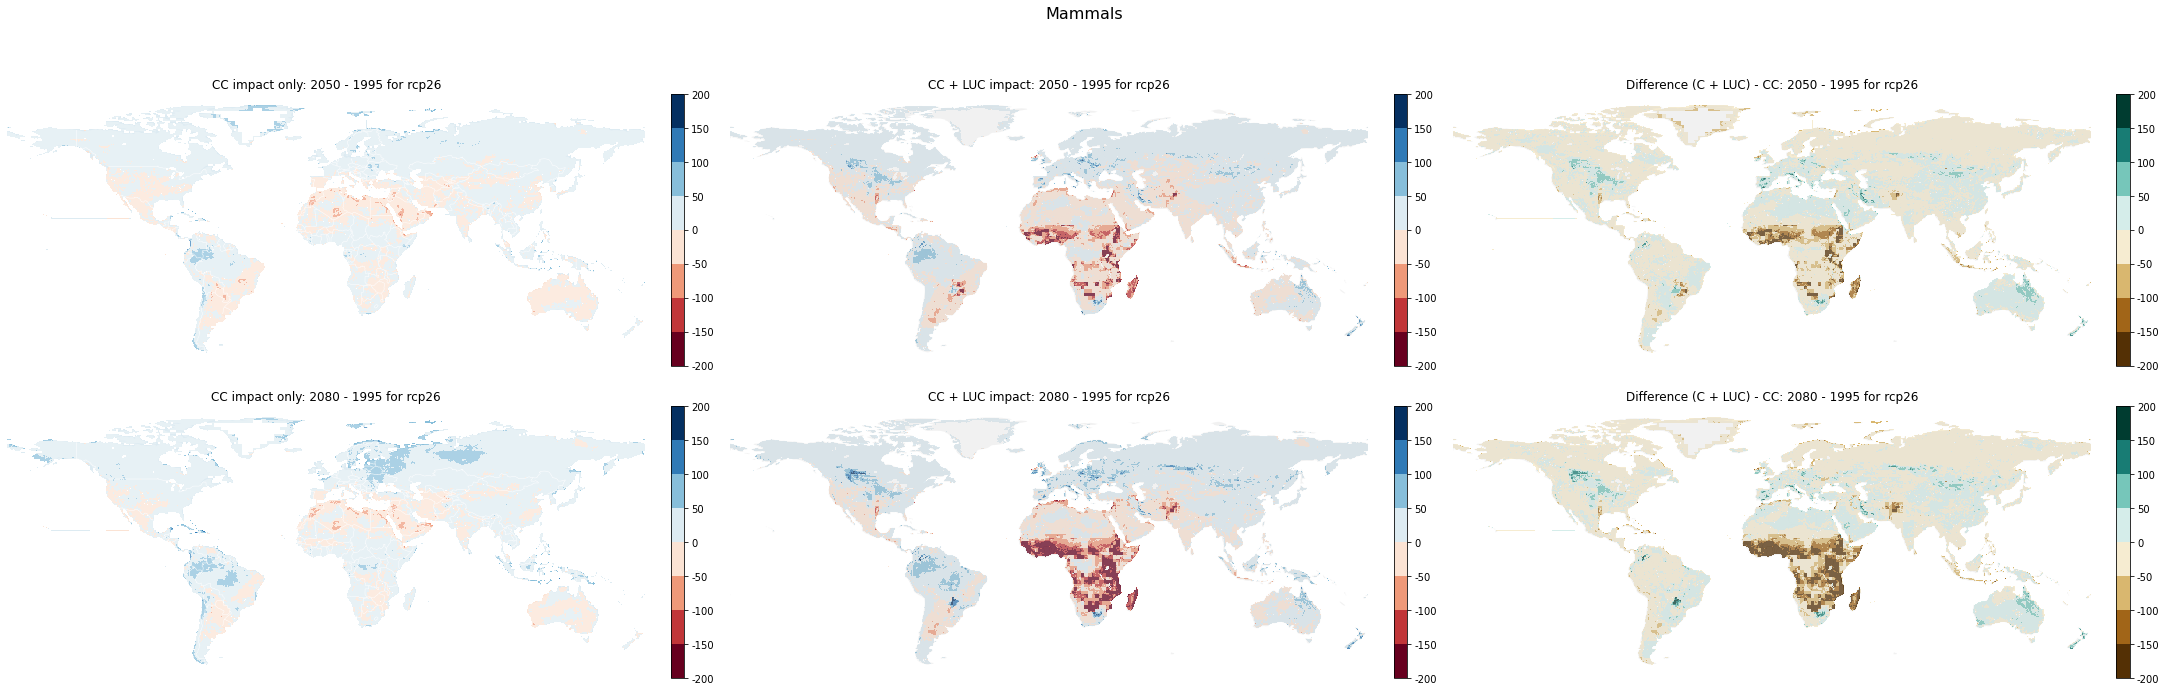

In [4]:
#### SDM MODEL ENSEMBLE RCP26 #####

models = ["GBM", "GAM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

#newvalue
for taxa in taxas:
    historical_time = 1146
    future_times = [35, 65]
    scenarios = ["rcp26"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

    # create empty arrays for storing the results
    diff_value_bin_combined = np.zeros([360, 720])
    diff_sum_bin_combined = np.zeros([360, 720])
    diff_combined = np.zeros([360, 720])

    
for future_time in future_times:
    diff_value_bin_models = []
    diff_sum_bin_models = []
    diff_models = []

    for model in models:
        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                        continue

            filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

            filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"



            mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
            mean_sum_bin_hist = xr.open_dataset(filename2,decode_times=False).to_array()
            #mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
            #mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)

            filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

            filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

            mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
            mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
            #mean_value_bin_future = mean_value_bin_future.isel(variable=0)
            #mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

            # Calculate the differences
            diff_value_bin = mean_value_bin_future - mean_value_bin_hist
            diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
            diff = diff_sum_bin - diff_value_bin

            # append the differences to the model-specific lists
            diff_value_bin_models.append(diff_value_bin)
            diff_sum_bin_models.append(diff_sum_bin)
            diff_models.append(diff)

    # Calculate the ensemble mean outside of the inner loop
    diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
    diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")
    
    diff_value_bin_ensemble = diff_value_bin_ensemble.isel(variable=0)
    diff_sum_bin_ensemble = diff_sum_bin_ensemble.isel(variable=0)
    diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble
    
    # Create three subplots for each future time and scenario
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]
    ax3 = axes.flatten()[plot_idx + 2]

    labels = ['a', 'b', 'c']
    # Define the colormap and the range of values for the colorbar
    vmin_b = diff_sum_bin.min().values
    vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdBu']
    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_value_bin_ensemble['lon'].values, diff_value_bin_ensemble['lat'].values, np.where(diff_value_bin_ensemble.values != 0, diff_value_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
    cbar1.set_ticklabels(tick_labels)


    im2 = ax2.pcolormesh(diff_sum_bin_ensemble['lon'].values, diff_sum_bin_ensemble['lat'].values,  np.where(diff_sum_bin_ensemble.values != 0, diff_sum_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)

    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
    cbar2.set_ticklabels(tick_labels)


    # ------------------------------------------------
    # Panel c 


    boundaries = [-200, -150, -100, -50,0,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)
    cmap = plt.colormaps['BrBG']

    im3 = ax3.pcolormesh(diff_ensemble['lon'].values, diff_ensemble['lat'].values,  np.where(diff_ensemble.values != 0, diff_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
    ax3.set_title(f"Difference (C + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
 
    ax3.axis('off')
    ax3.set_extent((-180,180,-63,90))

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b)
    cbar3.set_ticklabels(tick_labels)
    # Increase the plot index by 3 to move to the next triplet of subplots
    plot_idx += 3


plt.suptitle(taxa , size=16, y=0.7)
plt.show() 


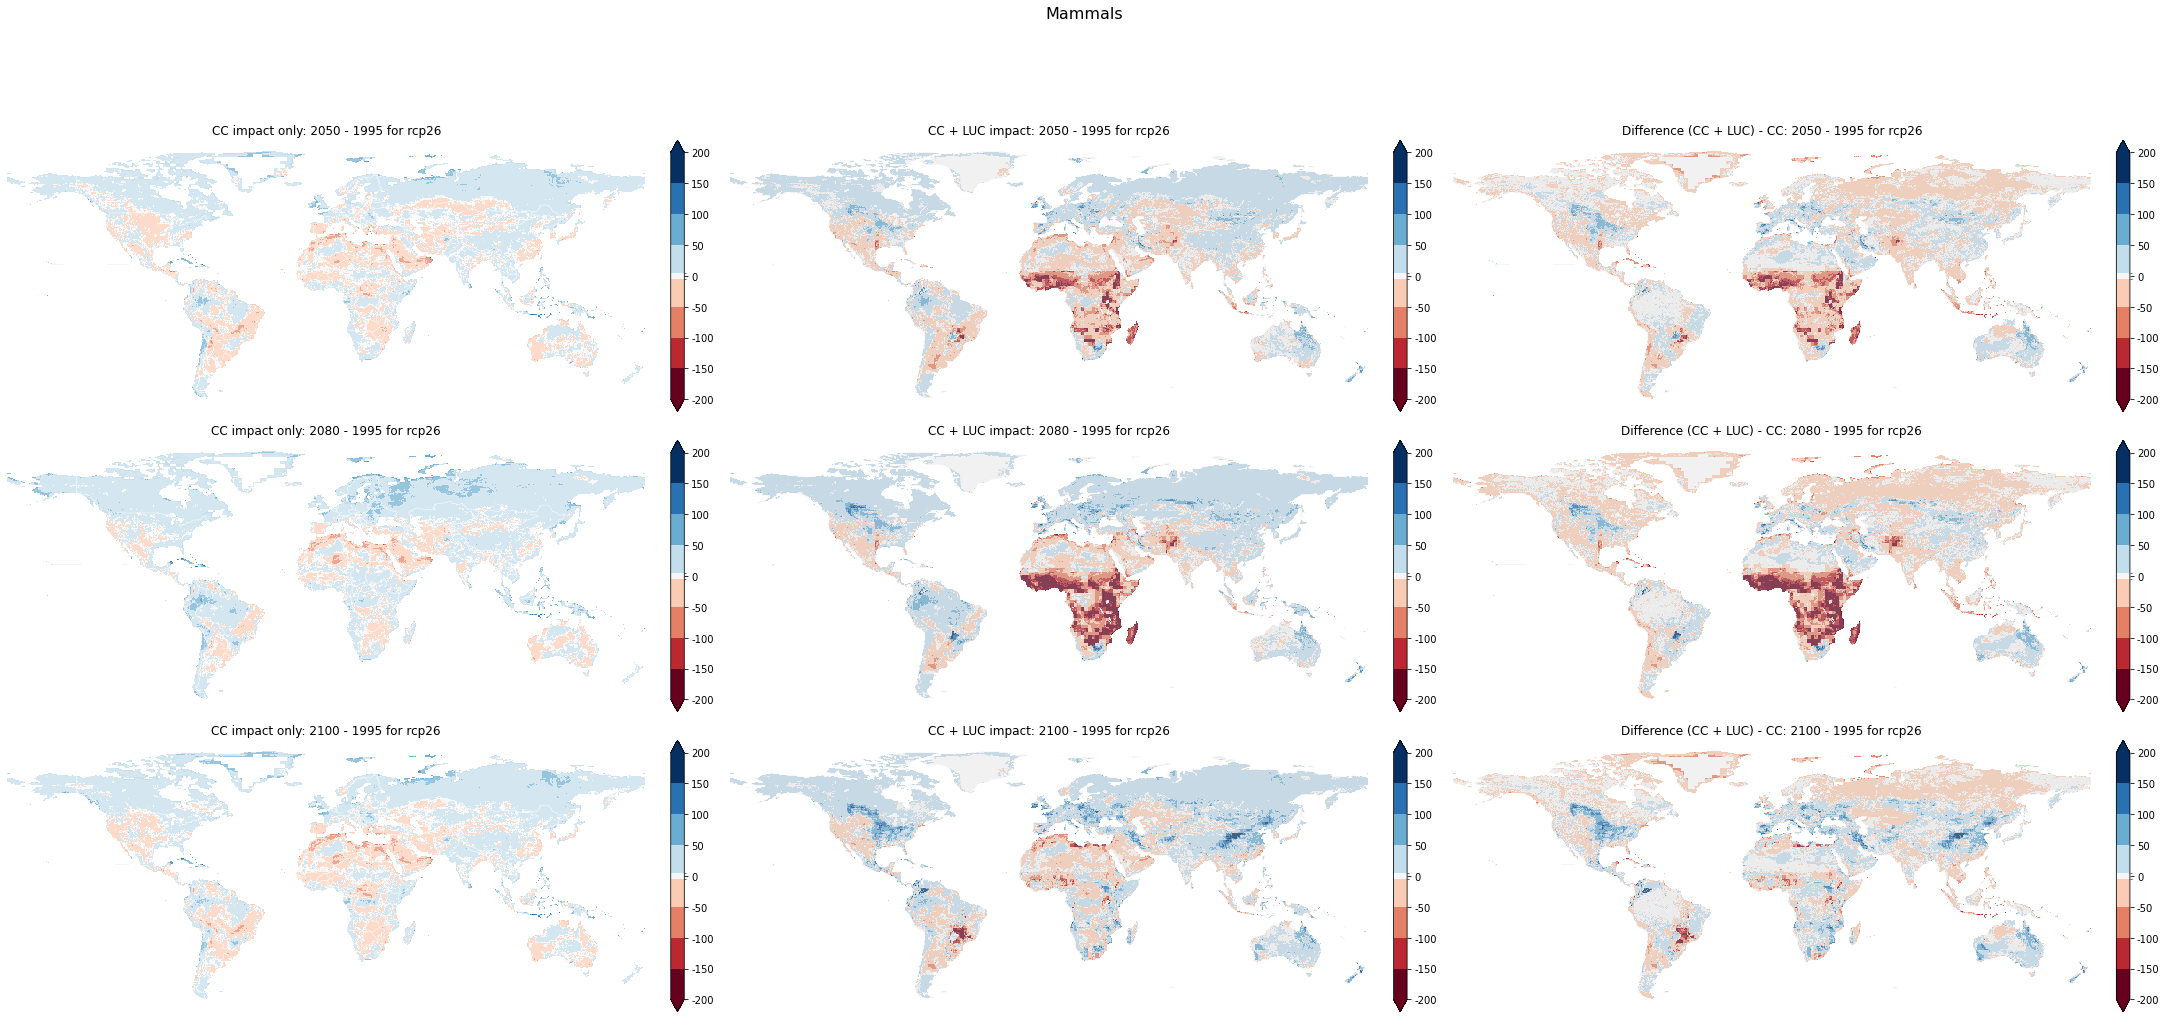

In [12]:
### SDM MODEL ENSEMBLE RCP26 ##### switched order  Mammals

warnings.filterwarnings('ignore', category=UserWarning)

models = ["GBM", "GAM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

#newvalue
for taxa in taxas:
    historical_time = 1146
    future_times = [35, 65,85]
    scenarios = ["rcp26"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

    # create empty arrays for storing the results
    diff_value_bin_combined = np.zeros([360, 720])
    diff_sum_bin_combined = np.zeros([360, 720])
    diff_combined = np.zeros([360, 720])

    
for future_time in future_times:
    diff_value_bin_models = []
    diff_sum_bin_models = []
    diff_models = []

    for model in models:
        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                        continue

            filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

            filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"



            mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
            mean_sum_bin_hist = xr.open_dataset(filename2,decode_times=False).to_array()
            #mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
            #mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)

            filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

            filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

            mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
            mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
            #mean_value_bin_future = mean_value_bin_future.isel(variable=0)
            #mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

            # Calculate the differences
            diff_value_bin = mean_value_bin_future - mean_value_bin_hist
            diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
            diff = diff_sum_bin - diff_value_bin

            # append the differences to the model-specific lists
            diff_value_bin_models.append(diff_value_bin)
            diff_sum_bin_models.append(diff_sum_bin)
            diff_models.append(diff)

    # Calculate the ensemble mean outside of the inner loop
    diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
    diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")
    
    diff_value_bin_ensemble = diff_value_bin_ensemble.isel(variable=0)
    diff_sum_bin_ensemble = diff_sum_bin_ensemble.isel(variable=0)
    diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble
    
    # Create three subplots for each future time and scenario
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]
    ax3 = axes.flatten()[plot_idx + 2]

    labels = ['a', 'b', 'c']
    # Define the colormap and the range of values for the colorbar
    vmin_b = diff_sum_bin.min().values
    vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdBu']
    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_value_bin_ensemble['lon'].values, diff_value_bin_ensemble['lat'].values, np.where(diff_value_bin_ensemble.values != 0, diff_value_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
      

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)


   
    im2 = ax2.pcolormesh(diff_sum_bin_ensemble['lon'].values, diff_sum_bin_ensemble['lat'].values,  np.where(diff_sum_bin_ensemble.values != 0, diff_sum_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)

    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)


    # ------------------------------------------------
    # Panel c 


    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)
    cmap = plt.colormaps['RdBu']

    im3 = ax3.pcolormesh(diff_ensemble['lon'].values, diff_ensemble['lat'].values,  np.where(diff_ensemble.values != 0, diff_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
    ax3.set_title(f"Difference (CC + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
 
    ax3.axis('off')
    ax3.set_extent((-180,180,-63,90))

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
    cbar3.set_ticklabels(tick_labels)
    # Increase the plot index by 3 to move to the next triplet of subplots
    plot_idx += 3


plt.suptitle(taxa , size=16, y=0.8)
fig.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/SR_" + taxa + "_" + model + "_" + scenario)

#plt.show() 


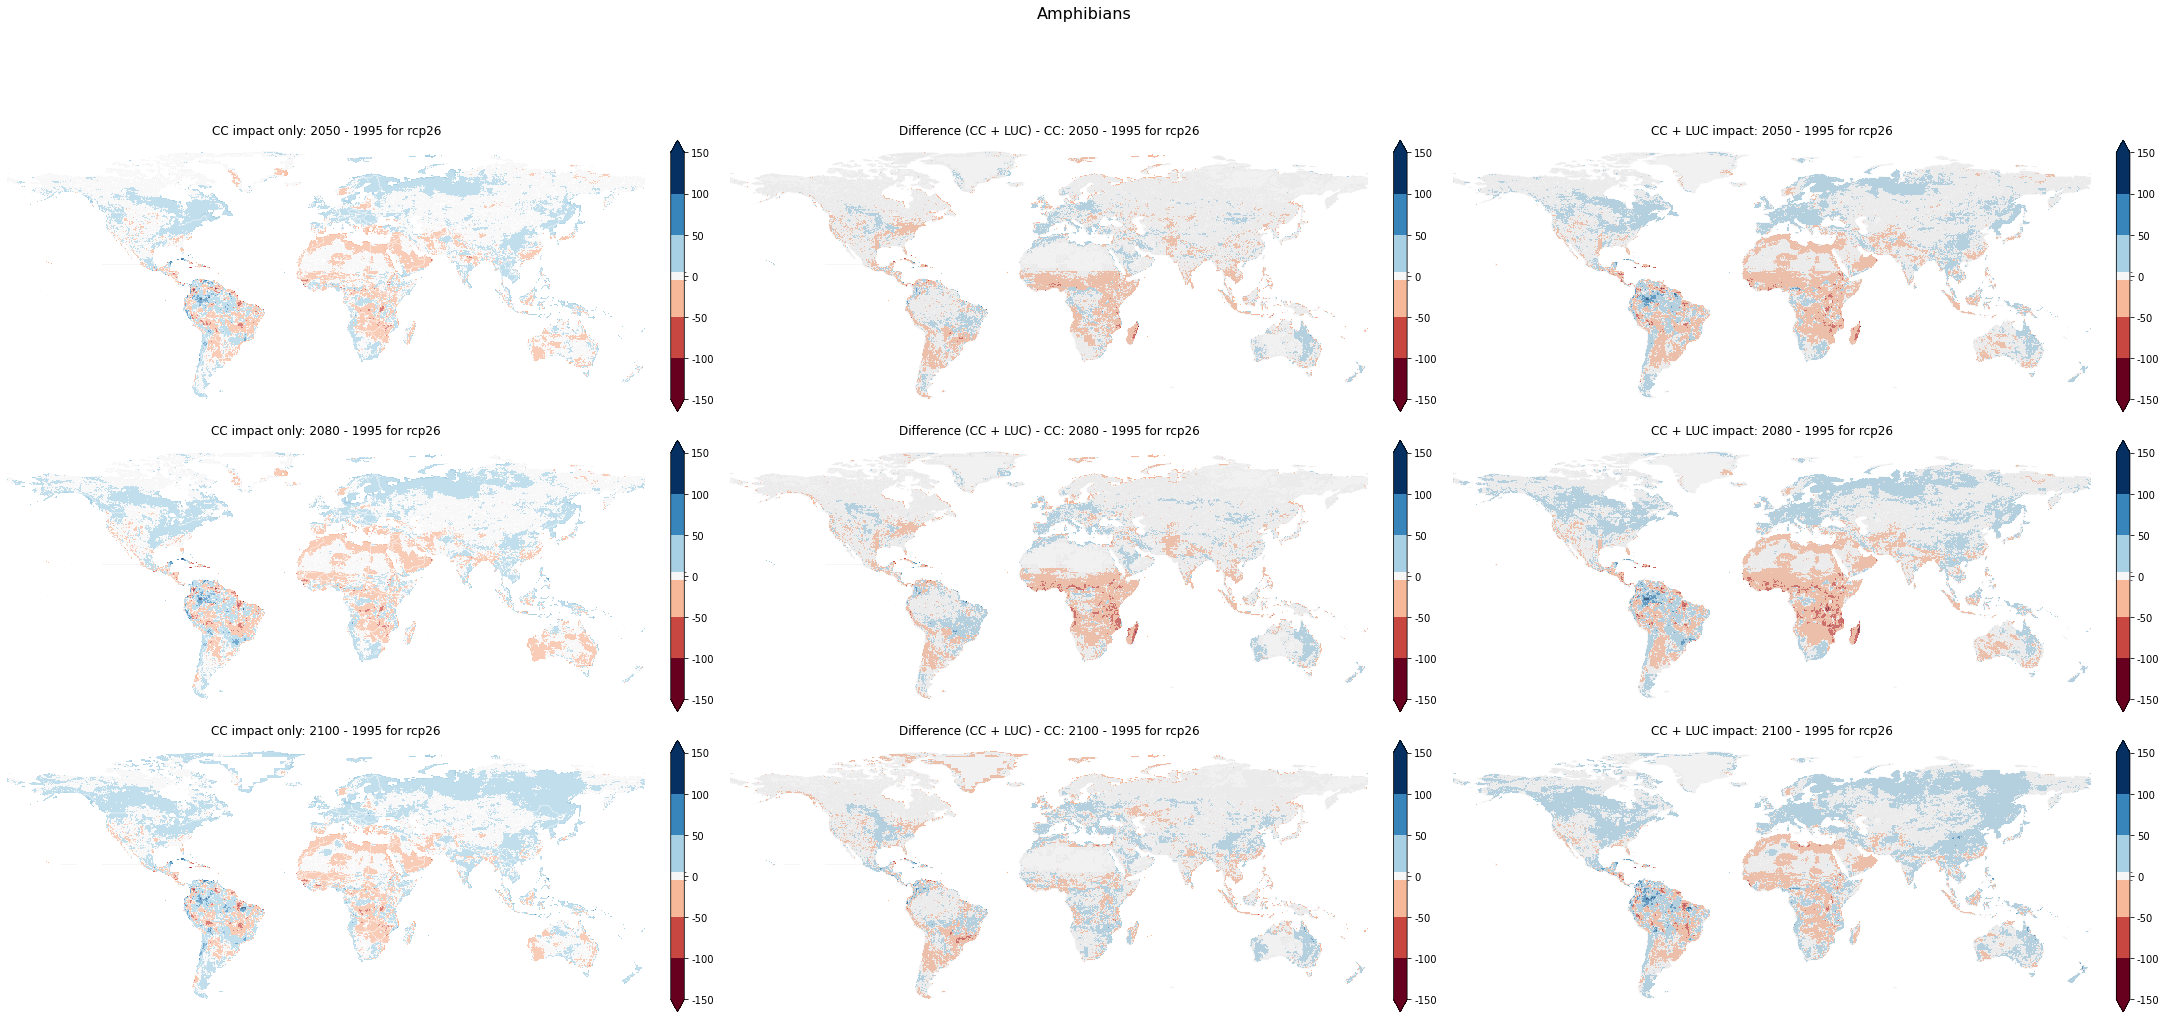

In [14]:
### SDM MODEL ENSEMBLE RCP26 ##### switched order  Amphibians

warnings.filterwarnings('ignore', category=UserWarning)

models = ["GBM", "GAM"]
taxas = ["Amphibians"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

#newvalue
for taxa in taxas:
    historical_time = 1146
    future_times = [35, 65,85]
    scenarios = ["rcp26"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

    # create empty arrays for storing the results
    diff_value_bin_combined = np.zeros([360, 720])
    diff_sum_bin_combined = np.zeros([360, 720])
    diff_combined = np.zeros([360, 720])

    
for future_time in future_times:
    diff_value_bin_models = []
    diff_sum_bin_models = []
    diff_models = []

    for model in models:
        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                        continue

            filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

            filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"



            mean_value_bin_hist = xr.open_dataset(filename,decode_times=False).to_array()
            mean_sum_bin_hist = xr.open_dataset(filename2,decode_times=False).to_array()
            #mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
            #mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)

            filename = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_value_bin_future.nc"

            filename2 = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_species_count_per_SCDM_05th_mean_sum_bin_future.nc"

            mean_value_bin_future = xr.open_dataset(filename,decode_times=False).to_array()
            mean_sum_bin_future = xr.open_dataset(filename2,decode_times=False).to_array()
            #mean_value_bin_future = mean_value_bin_future.isel(variable=0)
            #mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

            # Calculate the differences
            diff_value_bin = mean_value_bin_future - mean_value_bin_hist
            diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
            diff = diff_sum_bin - diff_value_bin

            # append the differences to the model-specific lists
            diff_value_bin_models.append(diff_value_bin)
            diff_sum_bin_models.append(diff_sum_bin)
            diff_models.append(diff)

    # Calculate the ensemble mean outside of the inner loop
    diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
    diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")
    
    diff_value_bin_ensemble = diff_value_bin_ensemble.isel(variable=0)
    diff_sum_bin_ensemble = diff_sum_bin_ensemble.isel(variable=0)
    diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble
    
    # Create three subplots for each future time and scenario
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 2]
    ax3 = axes.flatten()[plot_idx + 1]

    labels = ['a', 'b', 'c']
    # Define the colormap and the range of values for the colorbar
    vmin_b = diff_sum_bin_ensemble.min().values
    vmax_b = diff_sum_bin_ensemble.max().values

    cmap = plt.colormaps['RdBu']
    boundaries = [-150, -100, -50,-5,5,50, 100, 150] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_value_bin_ensemble['lon'].values, diff_value_bin_ensemble['lat'].values, np.where(diff_value_bin_ensemble.values != 0, diff_value_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
    ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
      

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array([-150, -100, -50,0,50, 100, 150])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)


   
    im2 = ax2.pcolormesh(diff_sum_bin_ensemble['lon'].values, diff_sum_bin_ensemble['lat'].values,  np.where(diff_sum_bin_ensemble.values != 0, diff_sum_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)

    ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)


    # ------------------------------------------------
    # Panel c 


    boundaries = [-150, -100, -50,-5,5,50, 100, 150] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)
    cmap = plt.colormaps['RdBu']

    im3 = ax3.pcolormesh(diff_ensemble['lon'].values, diff_ensemble['lat'].values,  np.where(diff_ensemble.values != 0, diff_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
    ax3.set_title(f"Difference (CC + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')
 
    ax3.axis('off')
    ax3.set_extent((-180,180,-63,90))

    ticks_b = np.array( [-150, -100, -50,0,50, 100, 150])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar3.set_ticklabels(tick_labels)
    # Increase the plot index by 3 to move to the next triplet of subplots
    plot_idx += 3


plt.suptitle(taxa , size=16, y=0.8)
fig.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/all_times_SR_" + taxa + "_" + model + "_" + scenario)

plt.show() 


In [113]:
diff_value_bin_ensemble.max()

<xarray.DataArray ()>
array(111.)
Coordinates:
    variable  <U8 'newvalue'

In [115]:
diff_sum_bin_ensemble.max()

<xarray.DataArray ()>
array(112.)
Coordinates:
    variable  <U7 'sum_bin'

In [117]:
diff_ensemble.max()

<xarray.DataArray ()>
array(116.5)

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


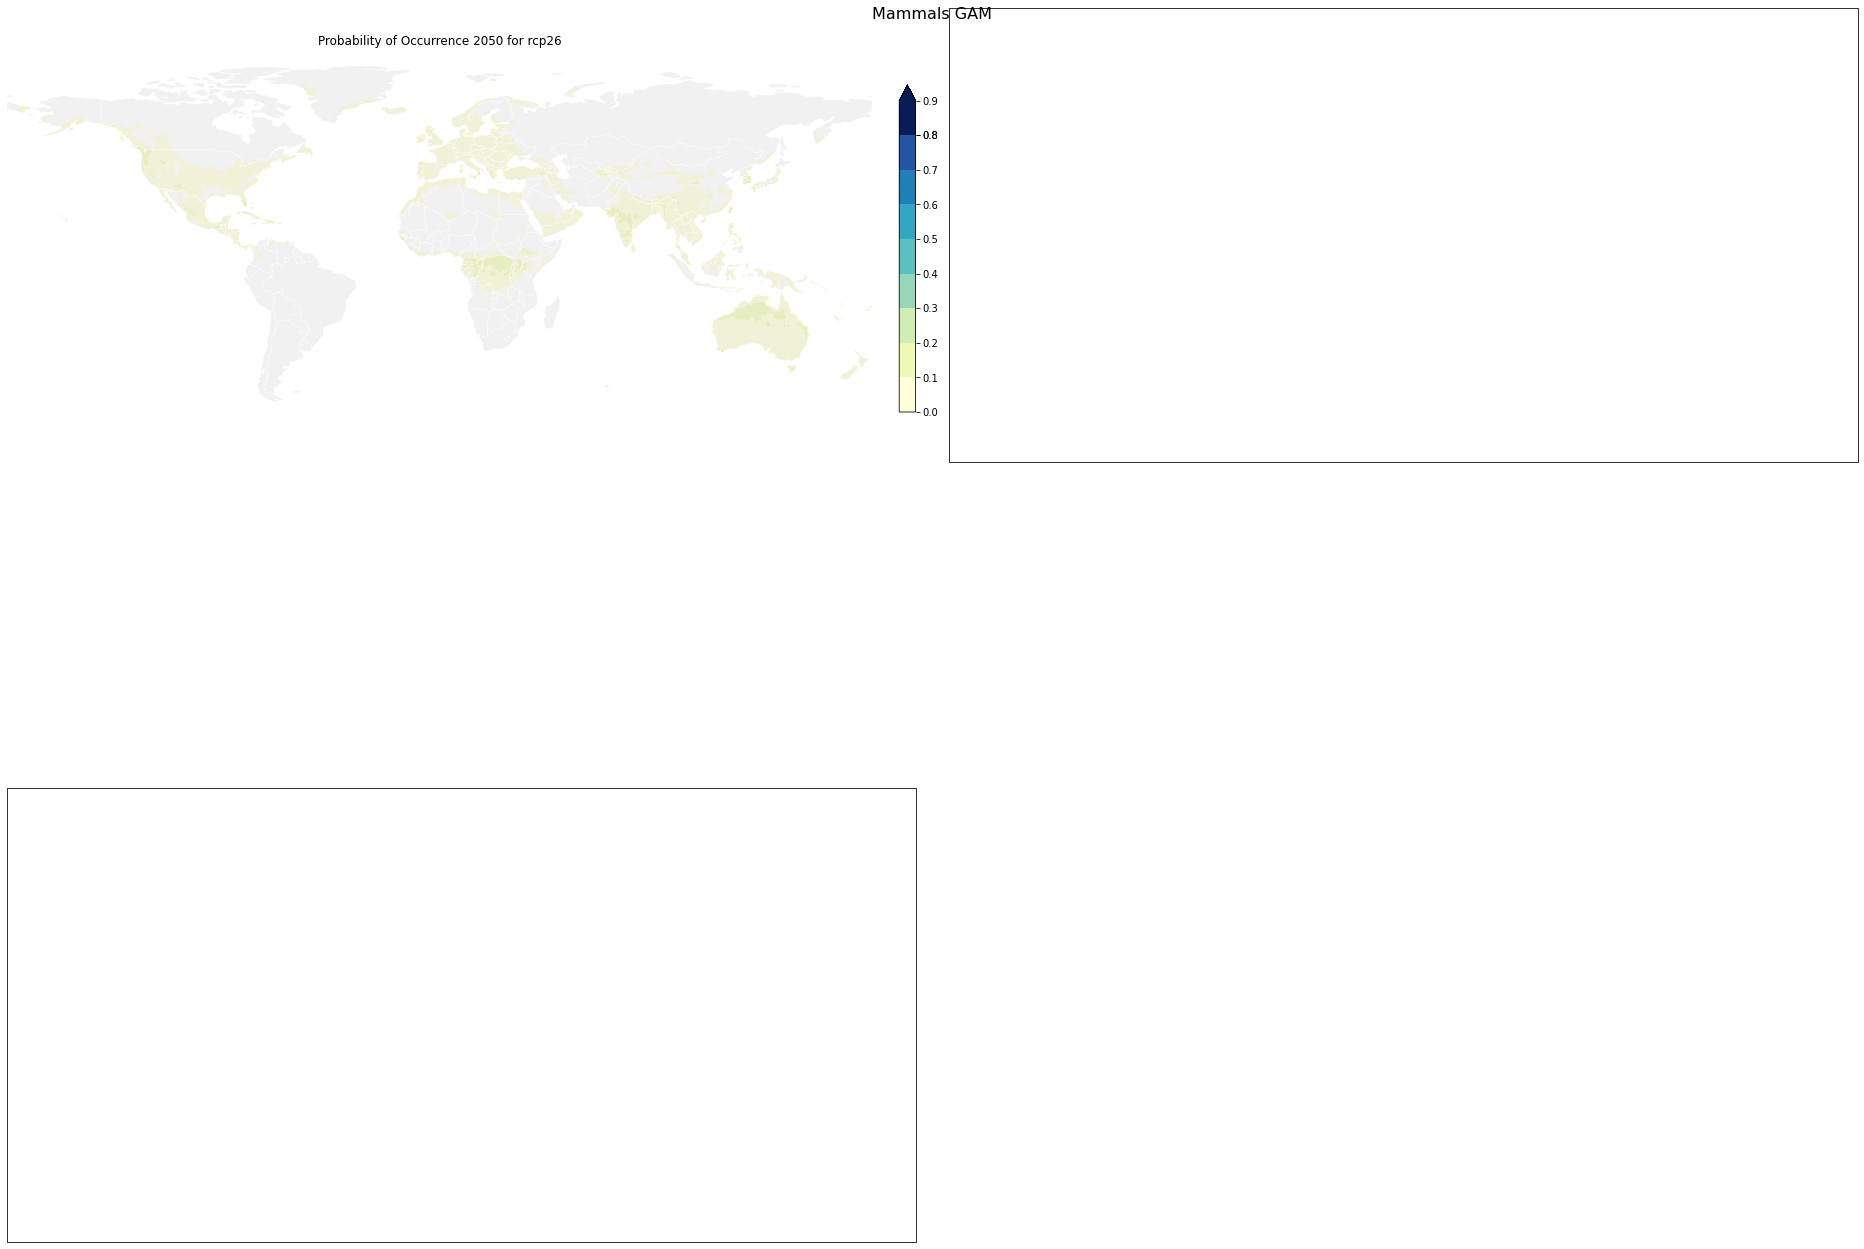

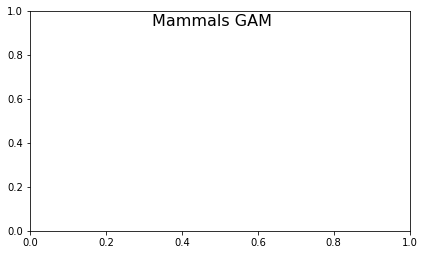

In [18]:
####FUTURE MEAN NEWVALUE  #####
##### Difference future - past ##### 
##### SDM results only ##### - SDM models seperate 


models=["GAM"] 
taxas =["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:5]

#newvalue
for taxa in taxas:
    for model in models:
        def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    newvalue = ds["newvalue"]
                    sum_bin = ds["sum_bin"]

                    newvalue_dict[model_name][species_name] = newvalue
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model_name in model_names:
                    value_bin = newvalue_dict[model_name][species_name]
                    value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

            return mean_value_bin


        #newvalue
historical_time = 1146
future_times = [35]
scenarios = ["rcp26", "rcp60"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

#mean_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26", "rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]

    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue

        mean_future = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)

        # Plotting code starts here
        cmap = plt.colormaps['YlGnBu']
        boundaries = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9] # Adjust these values according to your data
        norm = BoundaryNorm(boundaries, cmap.N)

        ax = axes.flatten()[plot_idx]
        im = ax.pcolormesh(mean_future['lon'].values, mean_future['lat'].values, np.where(mean_future.values != 0, mean_future.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

        countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
        ax.set_title(f"Probability of Occurrence {year_indices[future_time]} for {scenario}")

        cbar =  plt.colorbar(im, ax=ax, fraction=0.018, pad=0.03, spacing='proportional', ticks=ticks_b,extend='max')

        ax.axis('off')
        ax.set_extent((-180,180,-63,90))
        ax.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

        ticks_b = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9])
        tick_labels = [str(int(tick)) for tick in ticks_b]

        plot_idx += 1

        axes.flatten()[-1].set_visible(False)
    
    plt.suptitle(taxa + " " + model, size=16, y=0.85)

    plt.tight_layout()
    plt.show()




In [19]:
species_names =['Vulpes_vulpes']

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


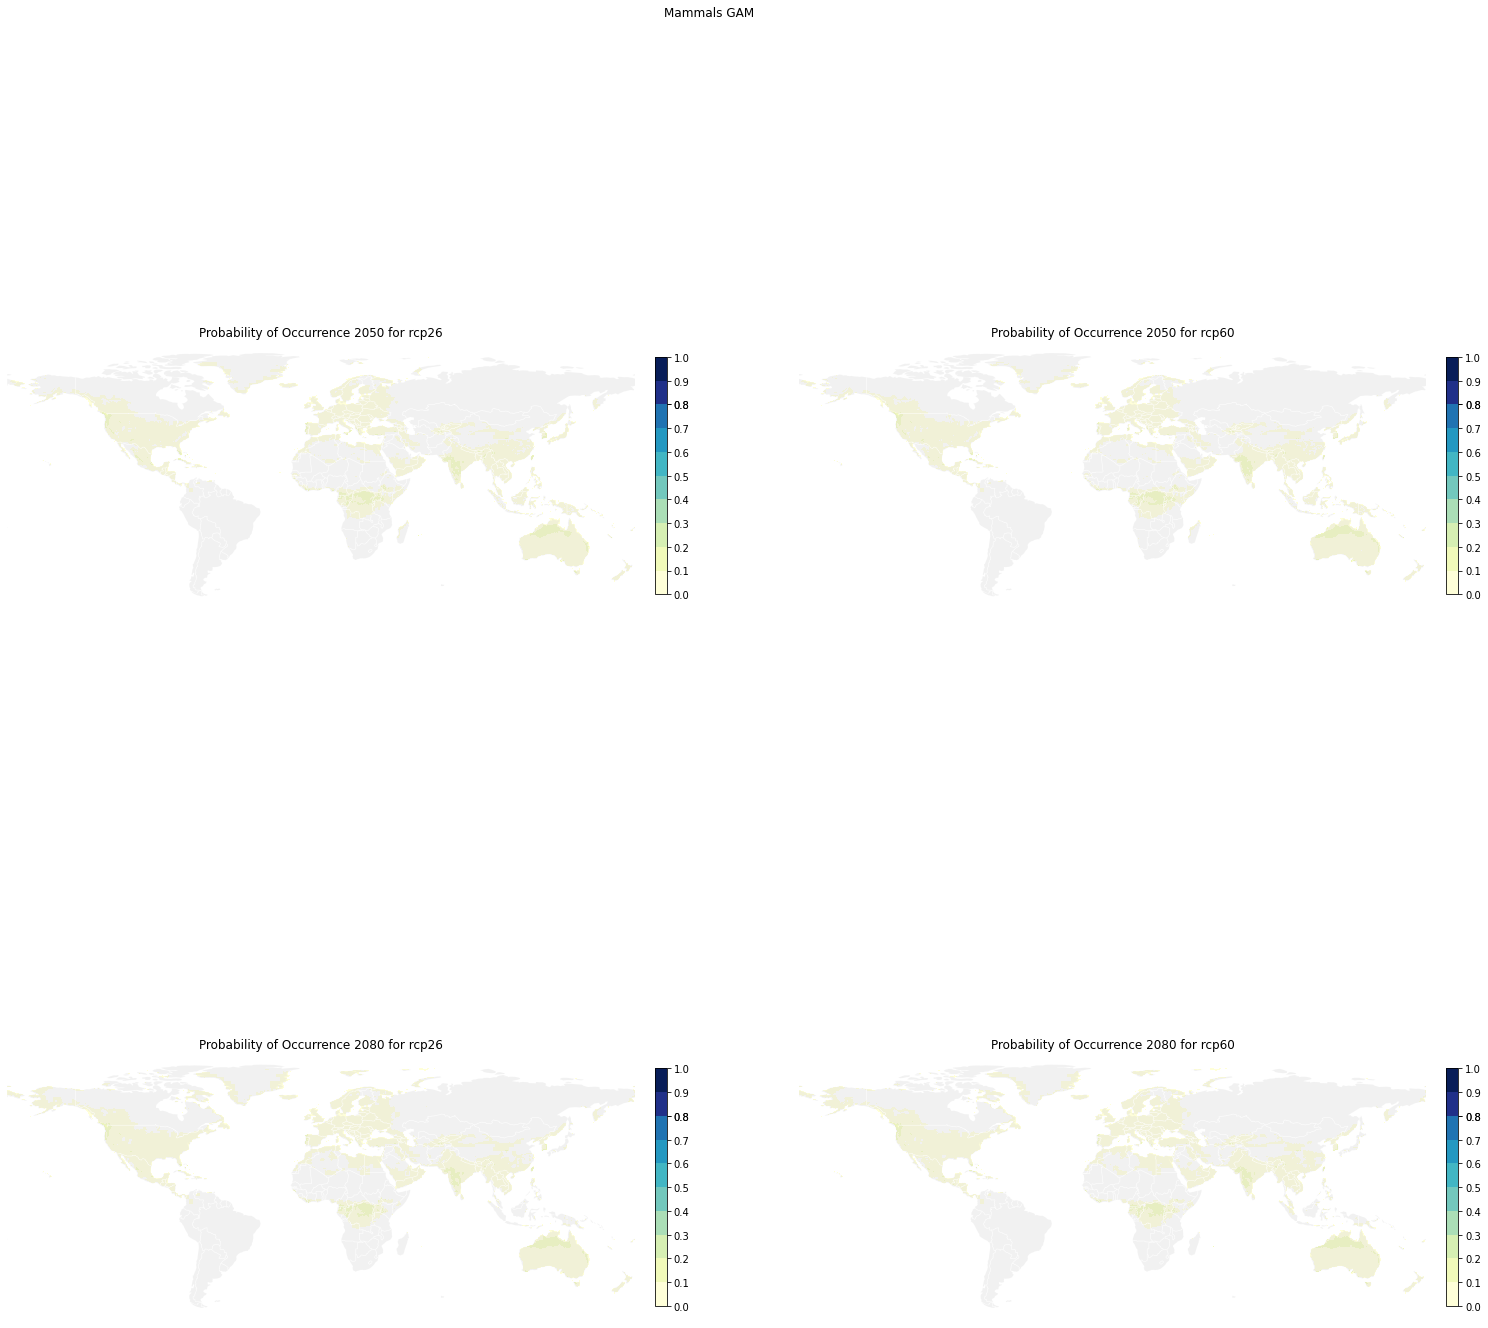

In [8]:
#### Comparison with vs without Land-use filter #### 
#one scenario at a time # 

models=["GAM"] 
taxas =["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:5]


for taxa in taxas:
    for model in models:


   
        def newvalue_fun(time, model, model_names,netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            
            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                        newvalue = ds["newvalue"]
                        sum_bin = ds["sum_bin"]

                        newvalue_dict[model][model_name][species_name] = newvalue
                        sum_bin_dict[model][model_name][species_name] = sum_bin

                projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model in models:
                    for model_name in model_names:
                        value_bin = newvalue_dict[model][model_name][species_name]
                        value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

            return mean_value_bin

future_times = [35, 65]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26","rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue

        # Call both functions and unpack their return values
        mean_value_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        #mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        # Calculate the difference between the two
        # diff_bin = mean_sum_bin -mean_value_bin

        # Create three subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]
        #ax2 = axes.flatten()[plot_idx + 1]


        # Plotting code starts here
        cmap = plt.colormaps['YlGnBu']
        boundaries = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1] # Adjust these values according to your data
        norm = BoundaryNorm(boundaries, cmap.N)

        im = ax1.pcolormesh(mean_value_bin_gam['lon'].values, mean_value_bin_gam['lat'].values, np.where(mean_value_bin_gam.values != 0, mean_value_bin_gam.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"Probability of Occurrence {year_indices[future_time]} for {scenario}")



        ax1.axis('off')
        ax1.set_extent((-180,180,-63,90))
        ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

        ticks_b = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1])
        tick_labels = [str(int(tick)) for tick in ticks_b]
        cbar =  plt.colorbar(im, ax=ax1, fraction=0.018, pad=0.03, spacing='proportional', ticks=ticks_b)

        # Increase the plot index by 2 to move to the next pair of subplots
        plt.suptitle(taxa + " " + model)
        plot_idx += 1
        fig.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/vulpes_vulpes_" + taxa + "_" + model + "_" + scenario)

In [7]:
species_names = ['Vulpes_vulpes']

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


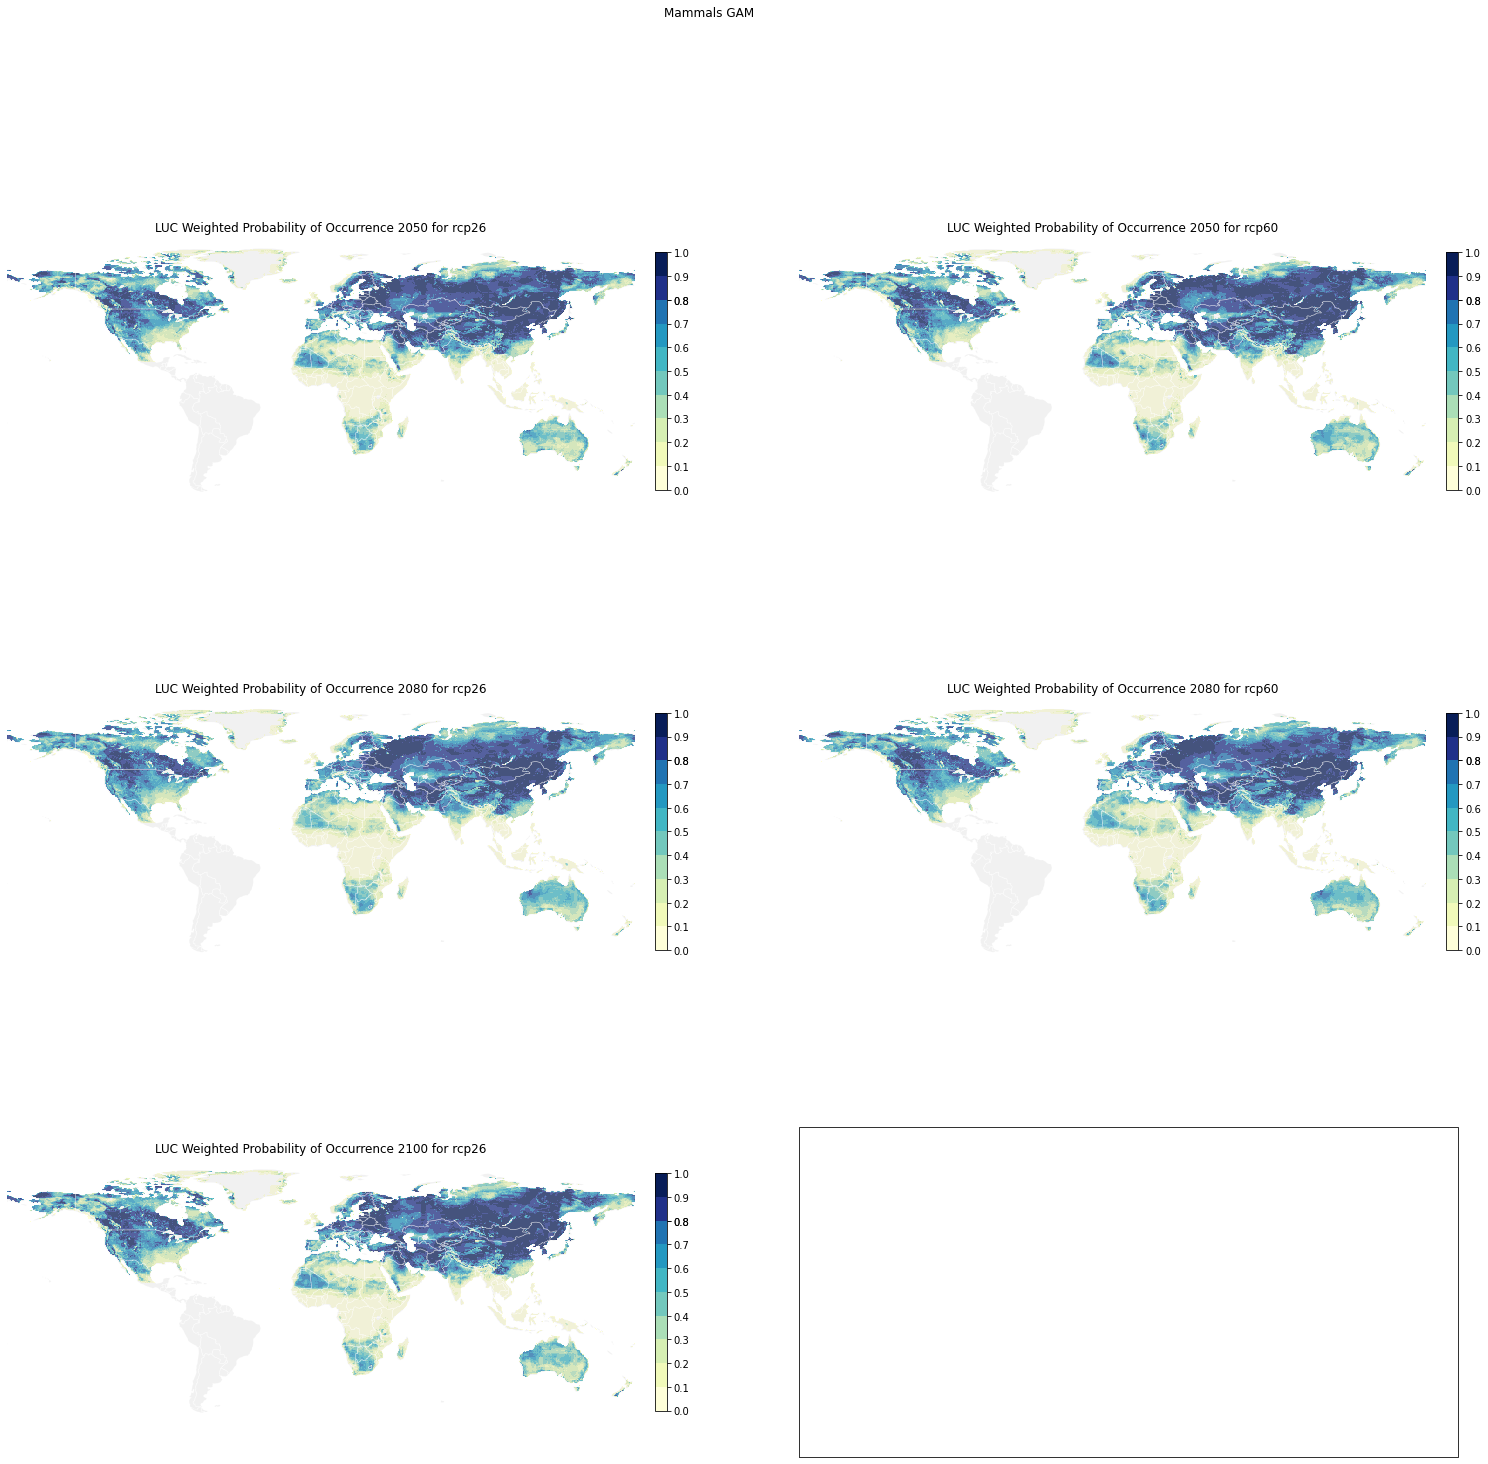

In [8]:
#### Comparison with vs without Land-use filter #### 
#one scenario at a time # 


models=["GAM"] 
taxas =["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
#model_names = ['GFDL-ESM2M']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:


   
        def newvalue_fun(time, model, model_names,netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            
            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                        #newvalue = ds["newvalue"]
                        sum_bin = ds["sum_bin"]

                        #newvalue_dict[model][model_name][species_name] = newvalue
                        sum_bin_dict[model][model_name][species_name] = sum_bin

                projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model in models:
                    for model_name in model_names:
                        value_bin = sum_bin_dict[model][model_name][species_name]
                        value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

            return mean_value_bin

future_times = [35, 65, 85]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26","rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue

        # Call both functions and unpack their return values
        mean_value_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        mean_value_bin_gam = mean_value_bin_gam.isel(time=0)
        #mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        # Calculate the difference between the two
        # diff_bin = mean_sum_bin -mean_value_bin

        # Create three subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]
        #ax2 = axes.flatten()[plot_idx + 1]


        # Plotting code starts here
        cmap = plt.colormaps['YlGnBu']
        boundaries = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1] # Adjust these values according to your data
        norm = BoundaryNorm(boundaries, cmap.N)

        im = ax1.pcolormesh(mean_value_bin_gam['lon'].values, mean_value_bin_gam['lat'].values, np.where(mean_value_bin_gam.values != 0, mean_value_bin_gam.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"LUC Weighted Probability of Occurrence {year_indices[future_time]} for {scenario}")



        ax1.axis('off')
        ax1.set_extent((-180,180,-63,90))
        ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

        ticks_b = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1])
        tick_labels = [str(int(tick)) for tick in ticks_b]
        cbar =  plt.colorbar(im, ax=ax1, fraction=0.018, pad=0.03, spacing='proportional', ticks=ticks_b)

        # Increase the plot index by 2 to move to the next pair of subplots
        plt.suptitle(taxa + " " + model)
        plot_idx += 1